# Phase 4 Final Project
Created by Lucas Fishbein

* Student name: Lucas Fishbein
* Student pace: Flex Program
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:  


# Overview and Business Problem

For many companies the traditional form of genreal advertising has been replaced with a much more highly targeted approach in which the demographics of their customerbases are very well understood and able to be more directly accessed. One of the many ways that companies recieve this type of information or feedback on their brand/products/services is through a more direct means of communication, the likes of which can be seen on websites like twitter or facebook. 




1. Be able to gauge some public opinion on a product/brand/service
    therefore make appropriate moves to mend or alter issues
2. Directly advertisments to those who already have shown interest in the product rather than cold calls.
3. get direct feedback from the consumers


# Data Analysis Results

# Database Understanding

The Present dataset contains a series of 9093 Tweets, the dataset has been pre-labeled by human raters. Raters judged if the tweet's text expressed a positive, negative or no emotion towards a brand and/or product, any time an emotion was expressed the rater was then asked to identify the brand or product that was the target of that emotion. 

The Tweets were in a large part centered on Apple and Google products during/after the 2011 South by Southwest (SXSW) Conference. The resulting datafile contains three columns per row, one for the tweet's text, one for the emotion expressed and one for the target product/brand of that emotion, when identifiable. 

Data was sourced from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions), added by Kent Cavender-Bares on August 30, 2013.



# Data Exploration 

### Importing Python Packages and Loading Data


In [1]:
#Importing Basic Packages
import numpy as np
import pandas as pd
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from PIL import Image
np.random.seed(42)


#Importing sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

#Importing os modules
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Importing nltk Packages
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.collocations import *

#Importing tensorflow and keras Packages
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D
from keras.models import Sequential
from keras.optimizers.legacy import RMSprop
from keras import initializers, regularizers, constraints, optimizers, layers
tf.random.set_seed(42)

from scikeras.wrappers import KerasClassifier


In [2]:
#Extracting data and creating DataFrame from CSV Data
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The Present dataset has three columns, the text of the tweet, the sentiment of the tweet and the product or brand that sentiment is directed at. The column headers will now be renamed for readability.

In [3]:
#Renaming columns for readability 
df.rename(columns = {'tweet_text': 'Original Tweet',
                    'emotion_in_tweet_is_directed_at': 'Item',
                    'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'}, inplace=True)

df.head()

,Original Tweet,Item,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Basic Data Exploration

Now that the DataFrame has more acceptable column headers, various aspects of the data such as datatype, missing or duplicated entries points and class balances will be examined in order to help determine preprocessing steps1 prior to modeling.

In [4]:
#Understanding Feature Datatype and null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Original Tweet  9092 non-null   object
 1   Item            3291 non-null   object
 2   Sentiment       9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


All Three columns are currently stored as objects, more specifically strings. It is also important to note that it seems the "Item" column is missing about two thirds of the datapoints, this is not detrimental to the current study as the brands and products the tweets are directed at are not the main focus of this project.

In [5]:
#Checking for duplicates and column unique value counts
df.describe()

,Original Tweet,Item,Sentiment
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


It looks like there may be a number of tweets that are duplicate entries, as there are less unique tweets than total tweets. It is also important to note that there are 9 distinct values in the item column while there are 4 different sentiment labels, these column values will be further explored below during data feature exporation.


In [6]:
#Checking for Missing Data
df.isna().sum()

Original Tweet       1
Item              5802
Sentiment            0
dtype: int64

There is only one missing tweet text value, which can will be removed. There are over 5800 missing "item" values but again, that is alright as the current project does not focus on the specific items but rather determining overall tweet sentiment. These missing values will be filled in with an "Uncategorized" classification.

In [7]:
#Checking for duplicates
print('The number of Duplicate entries are:', df.duplicated().sum())

df[df['Original Tweet'].isin(
    df['Original Tweet'][df['Original Tweet'].duplicated()\
                        ])].sort_values("Original Tweet")

The number of Duplicate entries are: 22


,Original Tweet,Item,Sentiment
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
774,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion


22 duplicate tweets were found and wil be removed so that the dataset lacks any sets of duplicates.

In [8]:
#Removing Null Tweets, Removing Duplicate entries and Filling in missing Item Values

#Removing 1 null 'Tweet' Entry
df.dropna(subset = ['Original Tweet'], inplace=True)

#Removing Duplicates
df.drop_duplicates(inplace=True)

#Filling in Null "Item" categories with "Uncategorized"
df['Item'].fillna('Uncategorized', inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Original Tweet  9070 non-null   object
 1   Item            9070 non-null   object
 2   Sentiment       9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


At this point there should not be any duplicate entries or null values in the data and our total row count in the dataset has gone from 9092 to 9070.

Next a deeper dive into each data feature will be taken in order to gain a better overall understanding and determine the next processing steps.

### Data Feature Exploration

#### Tweet Sentiment data

First, the values within the sentiment column will be examined and re-labeled to reflect a "Positive" or "Not Positive" sentiment in a new column. This will help allow the classification model to learn to determine what tweets are positive and which are not.

In [9]:
#Examining all Sentiment Labels
df['Sentiment'].value_counts()

Sentiment
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

There is a strong misbalance in the sentiment classifications of this data with there being almost 6x as many positive tweets than negative tweets. It is important to note that there are also over 5300 that were labeled as "no emotion," because our project goal is to identify Positive Tweets, the classes will now be reorganized into the categories: "Positive" and "Not Positive". 

The 156 "I can't tell" values will be removed as this unlabeled data is less helpful when building a classification model.

In [10]:
#Dropping "I can't tell" sentiment rated tweets
df.drop(df[df['Sentiment'] == "I can't tell"].index, inplace=True)

#Creating copy of original sentiment to preserve for possible later use
df['Original_Sentiment'] = df['Sentiment']

#Changing Sentiments to 'positive' and 'not positive'
senti_replace = {'No emotion toward brand or product' : 'Not Positive',
                'Positive emotion' : 'Positive',
                'Negative emotion' : 'Not Positive',
                 "I can't tell" : 'Unknown'
                }
df = df.replace({'Sentiment': senti_replace})

print(df['Sentiment'].value_counts())
df.head()

Sentiment
Not Positive    5944
Positive        2970
Name: count, dtype: int64


,Original Tweet,Item,Sentiment,Original_Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Not Positive,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Not Positive,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Positive emotion


Now the Dataframe is one step closer to being ready for binary classification modeling as now we have two distinct sentiment classes, the classes are still unbalanced at a ratio of about 1:2.

In [11]:
#Sentiment Class Sanity Check
print(df['Sentiment'].value_counts())
df['Original_Sentiment'].value_counts()

Sentiment
Not Positive    5944
Positive        2970
Name: count, dtype: int64


Original_Sentiment
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
Name: count, dtype: int64

## Adding Additional Feature Columns

At this point what information will be helpful is not entirely clear so a few extra features such as the brand associated with the tweet, extracting the Hashtags within the tweet and the number of words in the tweet will be labeled for future experimentation.


In [12]:
#Building a Helper Function to Extract the brand 

def extract_brand(Item, Tweet): 
    '''
    Takes in an item name as a string and secondary string, in this case a tweet, checks the item text first and 
    then the secondary string text for mention of words or letter strings that are associated with either Apple or Google Products.
    If a flagged string is within the item text, it is labeled with the appropriate brand.
    If a flagged is not within the item label, the tweet text then is examined for the brand associated strings and 
    labeled with the appropriate brand. If more than one brand is mentioned in the tweet, the tweet is labeled
    as "Contains Both".
    
    The output is the creation of a 'Brand' column in a DataFrame, named 'df', which will display the brand label, or 
    the categorization as "Unknown" if none of the brand associated strings are present.
    '''
    
    brand = 'Unknown' 
    #Checking if Item text contains brand key words
    
    #Labeling Google
    if ((Item.lower().__contains__('android')) or (Item.lower().__contains__('google'))): 
        brand = 'Google'
    #Labeling Apple    
    elif ((Item.lower().__contains__('apple')) or (Item.lower().__contains__('ip'))): 
        brand = 'Apple' 
        
    #If brand still unknown, checks tweet text for strings
    if (brand == 'Unknown'): 
        is_google = (Tweet.lower().__contains__('google')) or (Tweet.lower().__contains__('android')) #Undetermined google
        is_apple = (Tweet.lower().__contains__('apple')) or (Tweet.lower().__contains__('ip')) #Undetermined apple
        #if brand identifiers from both brands are in the tweet
        if (is_google and is_apple): 
            brand = 'Contains Both' 
        elif (is_google):
            brand = 'Google' 
        elif (is_apple):
            brand = 'Apple' 
    
    return brand

df['Brand'] = df.apply(lambda x: extract_brand(x['Item'], x['Original Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

Brand
Apple            5268
Google           2707
Unknown           733
Contains Both     206
Name: count, dtype: int64

The vast majority of our tweets were successfully labeled via the extract_brand function with their brands, only about 8% of the tweets remain unknown.

The next step creates a new column that contains the Hashtags present in the tweet, another new column for the number of words in the tweet as well as creating a column that is an exact copy of the original tweet that will be used to maintain the original tweet text after processing the tweet.

In [13]:
#Extracting hashtags and creating Column for them
df['Hashtag'] = df['Original Tweet'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

#Creating a tweet word length column
df['Tweet Length'] = df['Original Tweet'].str.split().str.len()

#This will be the tweet text that is preprocessed
df['Processed_Tweet'] = df['Original Tweet']

df.head()
                  

,Original Tweet,Item,Sentiment,Original_Sentiment,Brand,Hashtag,Tweet Length,Processed_Tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Not Positive,Negative emotion,Apple,"[#RISE_Austin, #SXSW]",23,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Positive emotion,Apple,[#SXSW],22,@jessedee Know about @fludapp ? Awesome iPad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Positive emotion,Apple,"[#iPad, #SXSW]",15,@swonderlin Can not wait for #iPad 2 also. The...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Not Positive,Negative emotion,Apple,[#sxsw],15,@sxsw I hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Positive emotion,Google,[#SXSW],17,@sxtxstate great stuff on Fri #SXSW: Marissa M...


After some feature engineering the dataframe now contains 8 columns including a "Processed_Tweet" column that presently is an exact copy of the original tweet, this column will be used during the preprocessing steps to alter the tweet text to prepare it for modeling.

## Preprocessing Tweet Text prior to Modeling

In NLP modeling, there are a number of basic text cleaning steps that often need to be completed, in this case this includes removing extraneous characters such as punctuation, urls, hashtags, putting all text in lowercase form and removing typical stopwords. This editting will be followed by tokenization an then lemmatization of these tokens so that the result is a list of lemmatized words seperated as tokens for each tweet.

A function will be built out that takes in a tweet's text and then completes the cleaning, tokenizing and lemmatization steps mentioned above.


In [14]:
#Lemitization and cleaning of the Tweet text


def tweet_cleaner_and_lemmer(Tweet, stop_words):
    '''
    Function takes in a string, in this case a tweet, and then a list of stop words. The string is first cleaned of
    any website links, hashtags, twitter usernames or punctuation. The string is then tokenized into separate 
    words via the nltk word_tokinize function and then any tokens that are not included in the stop words list 
    are returned as part of a list of tokens.
    '''
    #Instantiating the Lemmatizer 
    lemmatizer = WordNetLemmatizer()
    
    #removing urls, hashtags and twitter usernames from Tweets
    Tweet = re.sub('http\S+', '', str(Tweet))
    Tweet = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', str(Tweet)) #Removing URLs with www
    Tweet = re.sub(r'{link}', '', str(Tweet)) #Removing {link} from tweets
    Tweet = re.sub('#\S+', '', str(Tweet))
    Tweet = re.sub(r'@[A-Za-z0-9]+','', str(Tweet))
    

    #Removes Punctuation and makes lower case
    for i in string.punctuation:
        Tweet = Tweet.replace(i, '').lower()
    
    #Using stopwords from nltk to filter out stopwords

    tokens = nltk.word_tokenize(Tweet)
    
    Tweet_tokens = []
    
    for token in tokens:
        if token.lower() not in stop_words:
            Tweet_tokens.append(lemmatizer.lemmatize(token))
            
    return Tweet_tokens

It is important to remember the goal of this analysis is to extract the emotional sentiment of the tweet, in order to assure no data is lost, the generic stopwords list from ntlk will be edited to assure it does not include any words that may help in our emotion analysis.

In [15]:
#Examing ntlk english stopwords list
stop_words = stopwords.words('english')
stop_words.sort()
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [16]:
#Redefining A Modified Stopwords list
stop_words = ['a', 'about', 'after', 'ain', 'all',
              'am', 'an', 'and', 'any', 'as', 'at',
              'be', 'been', 'before', 'being', 'but',
              'by', 'd', 'do', 'does', 'doing',
              'don', 'down', 'during', 'each', 'few',
              'for', 'from', 'further', 'he', 'her',
              'here', 'hers', 'herself', 'him', 'himself',
              'his', 'how', 'i', 'if', 'in', 'into',
              "it's", 'its', 'itself', 'just', 'll', 'm',
              'ma', 'me', 'my', 'myself', 'o', 'of', 'off',
              'on', 'once', 'only', 'or', 'other',
              'our', 'ours', 'ourselves', 'out', 'over',
              'own', 're', 's', 'same', "she's", 'so',
              'some', 'such', 't', 'than', 'that',
              "that'll", 'the', 'their', 'theirs',
              'them', 'themselves', 'then', 'there',
              'these', 'they', 'this', 'those', 'through',
              'to', 'too', 'under', 'until', 'up', 've',
              'we', 'what', 'when', 'where', 'which', 'while',
              'who', 'whom', 'why', 'will', 'with', 'won',
              'y', 'you', "you'd", "you'll", "you're",
              "you've", 'your', 'yours', 'yourself', 'yourselves']


In [17]:
#Applying Tweet cleaner and lemmatizer function
df['Processed_Tweet'] =  df['Processed_Tweet'].apply(lambda x: tweet_cleaner_and_lemmer(x, stop_words))

df['Processed_Tweet'].head()

0    [have, 3g, iphone, 3, hr, tweeting, it, wa, de...
1    [know, awesome, ipadiphone, app, youll, likely...
2              [can, not, wait, 2, also, should, sale]
3    [hope, year, festival, isnt, crashy, year, iph...
4    [great, stuff, fri, marissa, mayer, google, ti...
Name: Processed_Tweet, dtype: object

In [18]:
#Double Checking a number of tweets before and after processing
print(df['Original Tweet'][12])
print(df['Processed_Tweet'][12])
print('---------------------------------')
print(df['Original Tweet'][1231])
print(df['Processed_Tweet'][1231])
print('---------------------------------')
print(df['Original Tweet'][820])
print(df['Processed_Tweet'][820])
print('---------------------------------')

Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.
['foursquare', 'ups', 'game', 'time', 'still', 'prefer', 'far', 'best', 'looking', 'android', 'app', 'date']
---------------------------------
Apple set to open 5000 sqft. Pop up Store on Congress Ave. during #SXSW {link}
['apple', 'set', 'open', '5000', 'sqft', 'pop', 'store', 'congress', 'ave']
---------------------------------
Google to launch new social portal today at #SXSW?  {link}
['google', 'launch', 'new', 'social', 'portal', 'today']
---------------------------------


Now for every tweet in the dataset a cleaned, lemmitized, tokenized version exists. These tokens will be padded and then turned into arrays prior to being used in the model.

Much like before, a new column will be added that expresses the number of tokens present in the tweet as this may ellucidate a pattern within the data.

In [19]:
#Creating Token Count Column
df['Token Count'] = df['Processed_Tweet'].str.len()
df.head()

,Original Tweet,Item,Sentiment,Original_Sentiment,Brand,Hashtag,Tweet Length,Processed_Tweet,Token Count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Not Positive,Negative emotion,Apple,"[#RISE_Austin, #SXSW]",23,"[have, 3g, iphone, 3, hr, tweeting, it, wa, de...",13
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Positive emotion,Apple,[#SXSW],22,"[know, awesome, ipadiphone, app, youll, likely...",13
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Positive emotion,Apple,"[#iPad, #SXSW]",15,"[can, not, wait, 2, also, should, sale]",7
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Not Positive,Negative emotion,Apple,[#sxsw],15,"[hope, year, festival, isnt, crashy, year, iph...",8
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Positive emotion,Google,[#SXSW],17,"[great, stuff, fri, marissa, mayer, google, ti...",14


# Exploratory Data Analysis

The dataset will be examined to look for imbalances as well as any other general patterns or trends. Visualizations will be created to familiarize ourselves with the overall data further as well as help determine next steps in data preprocessing.

### Sentiment Breakdown 


[Text(0.5, 1.0, 'Number of Tweets by Sentiment')]

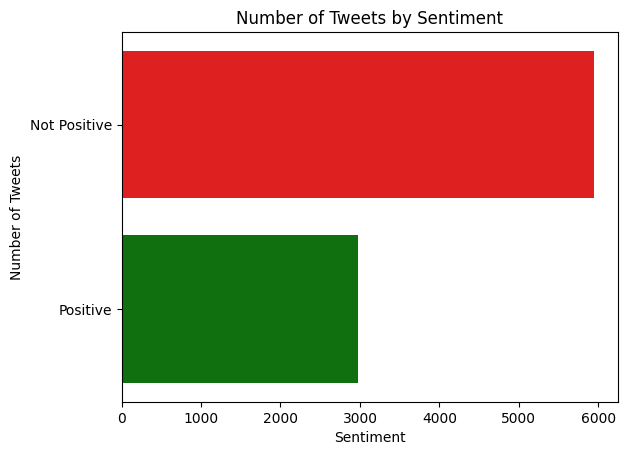

In [20]:
#Bar Graph of Sentiment Counts
sent_count = sns.countplot(data = df, y = 'Sentiment', palette=['red',"green"])
sent_count.set(ylabel = 'Number of Tweets')
sent_count.set(xlabel = 'Sentiment')
sent_count.set(title = 'Number of Tweets by Sentiment')

There is cleary a strong imbalance in the sentiments of this dataset with "not positive" tweets having about twice as many instances as positive tweets.

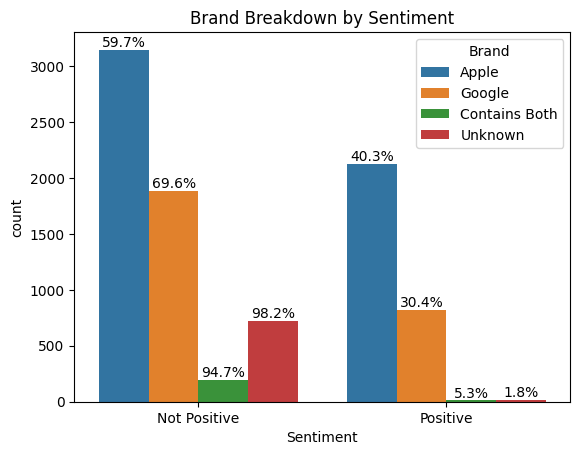

In [21]:
#Bar Graph of brand distribution by sentiment

vc = df.Brand.value_counts()

brands_by_sent = sns.countplot(data=df, x='Sentiment', hue='Brand')
brands_by_sent.set(title = 'Brand Breakdown by Sentiment')
for c in brands_by_sent.containers:
    label = c.get_label()
    total = vc[label]
    brands_by_sent.bar_label(c, fmt=lambda v: f'{(v/total)*100:0.1f}%')

This Graph shows the breakdown of sentiment by brand with the percentage of the distrobution of each brand located at the top of the bars. We can see that each brand is skewed towards not positive tweets.

## Item Distribution

[Text(0.5, 1.0, 'Number of Tweets per Item')]

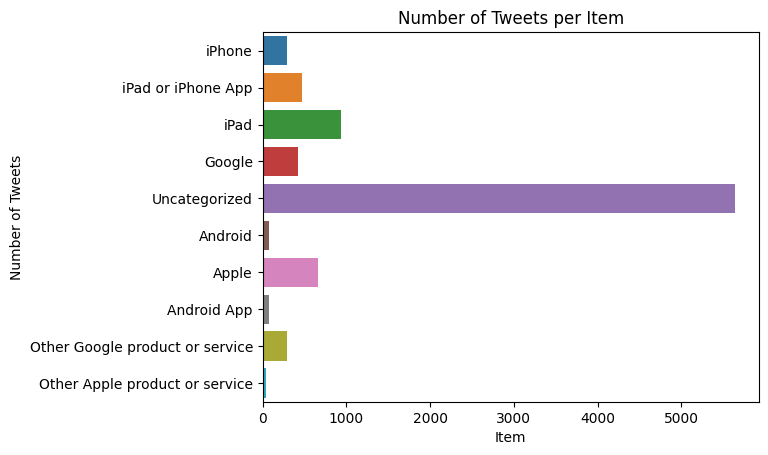

In [22]:
# Item Count Bar Graph
item_count = sns.countplot(data = df, y = 'Item')
item_count.set(ylabel = 'Number of Tweets')
item_count.set(xlabel = 'Item')
item_count.set(title = 'Number of Tweets per Item')

The vast majority of tweets were about an uncategorized brand/product with the iPad having the most tweets about it.

[Text(0.5, 1.0, 'Sentiments by Item')]

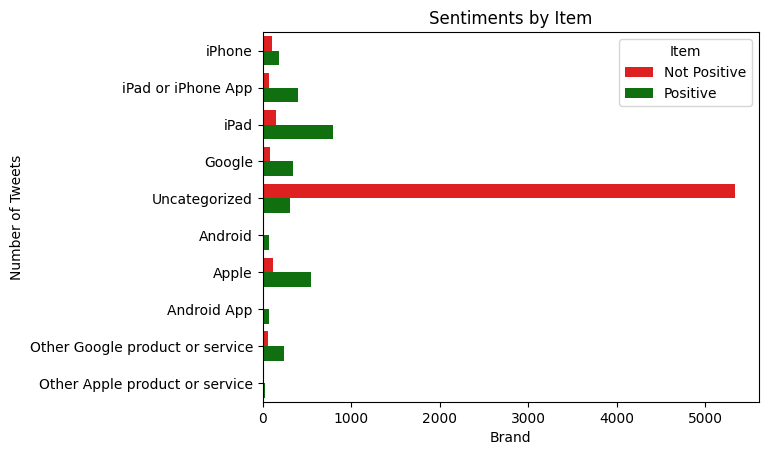

In [23]:
#Sentiment by Item Bar Graph

sent_item_bar = sns.countplot(data=df, y='Item', hue='Sentiment', palette=['red',"green"])
sent_item_bar.legend(title = 'Item', loc = 'upper right')
sent_item_bar.set(ylabel = 'Number of Tweets')
sent_item_bar.set(xlabel = 'Brand')
sent_item_bar.set(title = 'Sentiments by Item')

It seem from this chart that the majority of product/brand directed tweets were positive, as it can be seen that all items except the uncategorized have many more positive tweets than negative.

### Brand Distribution


[Text(0.5, 1.0, 'Number of Tweets by Brand')]

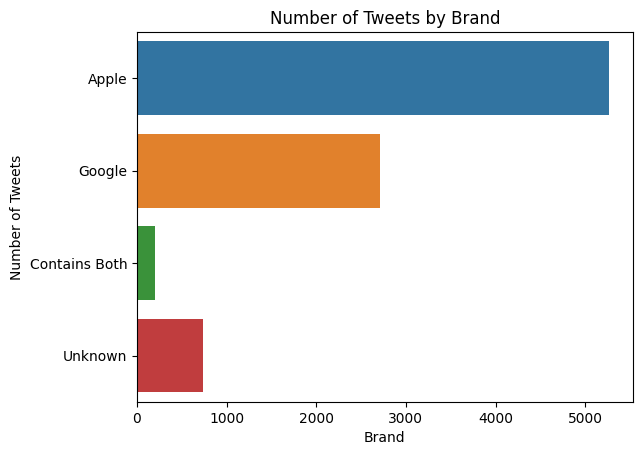

In [24]:
#Brand Tweet Count Bar Graph

brand_count = sns.countplot(data = df, y = 'Brand')
brand_count.set(ylabel = 'Number of Tweets')
brand_count.set(xlabel = 'Brand')
brand_count.set(title = 'Number of Tweets by Brand')

[Text(0.5, 1.0, 'Sentiments by Brand')]

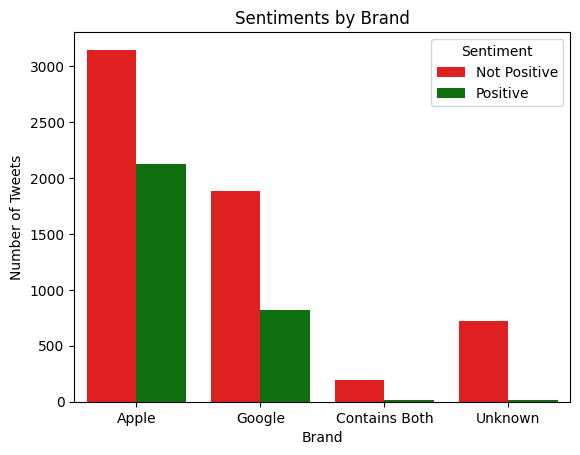

In [25]:
#Sentiment by Brand bar
sent_brand_bar = sns.countplot(data=df, x='Brand', hue='Sentiment', palette=['red',"green"])
sent_brand_bar.legend(title = 'Sentiment', loc = 'upper right')
sent_brand_bar.set(ylabel = 'Number of Tweets')
sent_brand_bar.set(xlabel = 'Brand')
sent_brand_bar.set(title = 'Sentiments by Brand')

It seems that although tweets about specific products or brands scewed in the positive direction, overall the majority of the tweets about the brands as a whole were mostly Not Positive, it is important to remember than "not positive' includes neutral feelings.

## Tweet Length/ Token Count by Sentiment

The tweets were then examined for the length of the tweet, since there are currently two forms of the tweet, the orginal and the cleaned, lemmatized token version, both will be examined

Text(0, 0.5, 'Number of Words')

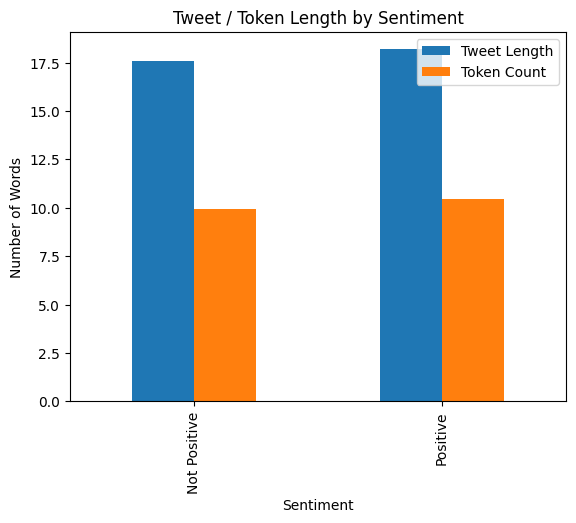

In [26]:
#Tweet/ Token Count by Sentiment bar
tweet_token_sent_bar = df.groupby(['Sentiment'])[['Tweet Length','Token Count']].mean().plot.bar()
tweet_token_sent_bar.set_title('Tweet / Token Length by Sentiment')
tweet_token_sent_bar.set_ylabel('Number of Words')



No obvious trends jump out beyond that there are on average less tokens than words in the origina tweet which is expected as the tweets were editted during their tokenization process.

Text(0, 0.5, 'Number of Words')

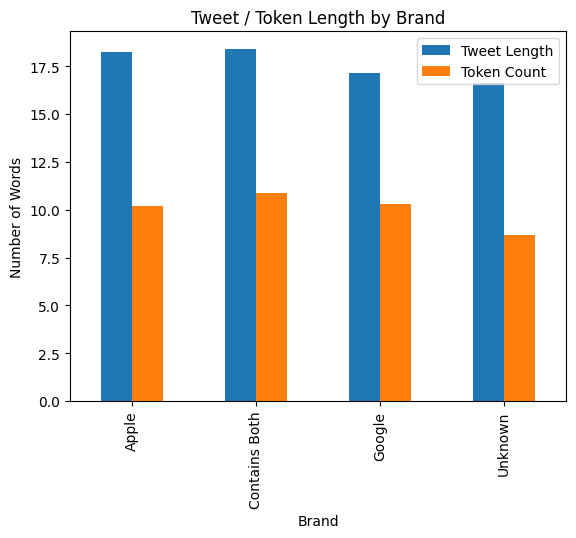

In [27]:
#Tweet/ Token Count by brand bar
tweet_token_brand_bar = df.groupby(['Brand'])[['Tweet Length','Token Count']].mean().plot.bar()
tweet_token_brand_bar.set_title('Tweet / Token Length by Brand')
tweet_token_brand_bar.set_ylabel('Number of Words')



Again no obvious useful trends jump out of this analysis.

## Hashtag Exploration
A common feature of Tweets are "Hashtags" which people often use to tag their post as applying to a certain community of posts. More info on hashtags can be found [here](https://help.twitter.com/en/using-twitter/how-to-use-hashtags#:~:text=A%20hashtag%E2%80%94written%20with%20a,to%20categorize%20Tweets%20by%20keyword)

The next analysis will examine these tags.

Prior to working with the hashtags, the first step will be to tokenize the list of hashtags scraped from each tweet.

In [28]:
#Creating a list of Hashtags from the hashtag column
hashtags_list = df['Hashtag'].to_list()

#Converting list to bag of words separating via commas
hashtag_bag = ','.join(map(str, hashtags_list))
#Converting Bag of words into tokens
hashtag_tokens = word_tokenize(hashtag_bag)
#Reformatting tokens in lowercase
hashtag_tokens = [x.lower() for x in hashtag_tokens]
hashtag_tokens[:10]

['[', "'", '#', 'rise_austin', "'", ',', "'", '#', 'sxsw', "'"]

Now that the hashtags are tokenized there are some punctations that will need to be removed to clean up this list.

Then the counts of each token will then be extracted.

In [29]:
#Defining punctuation as stopwords
hashtag_stopwords = list(string.punctuation)
#Removing punctuation from list of hashtag tokens
hashtag_tokens_clean = [token for token in hashtag_tokens if token not in hashtag_stopwords]

hashtag_freq = nltk.FreqDist(hashtag_tokens_clean)
hashtag_freq.most_common(10)

[('sxsw', 8935),
 ('apple', 413),
 ('google', 318),
 ('sxswi', 313),
 ('ipad2', 294),
 ('iphone', 262),
 ('ipad', 260),
 ('android', 130),
 ('austin', 110),
 ('circles', 97)]

There now exists a frequency distibution of hashtags throughout the dataset. A function will now be built out to create frequency distribution for each sentiment label, the top values of these  distributions will then be graphed and visualized via wordclouds in order to look for differences in hashtag use among different sentiments.

## Exploring Hashtags by Sentiment

In [30]:
def hashtag_wordcloud_bar(df, Sentiment):
    '''
    Input a DataFrame with a "Senitment" string column and a 'Hashtag' string column as well as a string 
    that is the sentiment label you would like to examine. The fuction creates a list of all of the words in 
    the Hashtag column by the sentiment choosen, the list is then made into a bag of words and tokenized. Tokens are
    then formatted as lowercase and punctation. 
    
    A frequency distribution of the tokens is then created and the top 15 words printed out, the top 40 tokens
    are visualized as a wordcloud and the top 8 tokens via a bar graph. 
    '''
    hashtag_df = df[df['Sentiment'] == Sentiment]

    #Creating a list of Hashtags from the hashtag column
    hashtag_list = hashtag_df['Hashtag'].to_list()
    #Converting list to bag of words separating via commas
    hashtag_bag = ','.join(map(str, hashtag_list))
    #Converting Bag of words into tokens
    hashtag_tokens = word_tokenize(hashtag_bag)
    #Reformatting tokens in lowercase
    hashtag_tokens = [x.lower() for x in hashtag_tokens]
    #Defining punctuation as stopwords
    hashtag_stopwords = list(string.punctuation)
    #removing punctuation from list of hashtag tokens
    hashtag_tokens_clean = [token for token in hashtag_tokens if token not in hashtag_stopwords]
    
    #Create Frequency Distribution
    hashtag_freq = nltk.FreqDist(hashtag_tokens_clean)

    #Printing top 15 tokens
    print('Top Ten Hashtags for', Sentiment, 'are:', hashtag_freq.most_common(15))
    
    
    #Conversion to pandas series for plotting
    hashtag_freq_series = pd.Series(dict(hashtag_freq.most_common(8)))
    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(x=hashtag_freq_series.index, y=hashtag_freq_series.values, ax=ax)
    plt.gca().set(title='Top 8 most Common Hashtags for {} Tweets'.format(Sentiment), ylabel='Hashtag Count')
    plt.xticks(rotation=30);
    
    #Building Wordcloud
    wordcloud = WordCloud(max_words = 40, collocations = False, 
                       background_color = 'black', colormap = 'prism') #Make wordcloud
    wordcloud.generate(",".join((hashtag_tokens_clean))) #Generates wordcloud from input list

    plt.figure(figsize = (8, 6), facecolor = None) #Set figure size
    plt.imshow(wordcloud) #Shows wordcloud
    plt.axis('off') #Sets axis
    plt.title('Word Cloud of {} Hashtags'.format(Sentiment)); #Set title of plot


Top Ten Hashtags for Positive are: [('sxsw', 2984), ('apple', 177), ('ipad2', 130), ('sxswi', 96), ('ipad', 93), ('iphone', 82), ('google', 69), ('android', 42), ('austin', 40), ('tech', 28), ('hollergram', 23), ('ubersocial', 21), ('tapworthy', 21), ('winning', 19), ('circles', 17)]


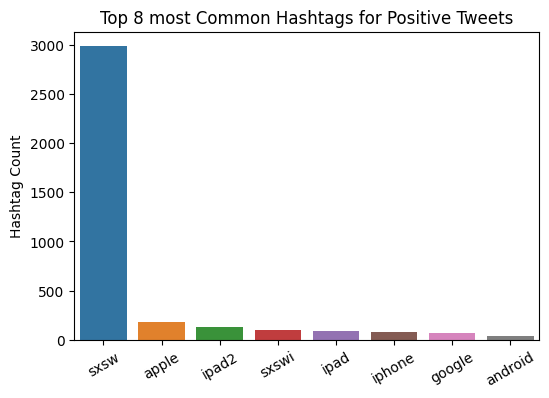

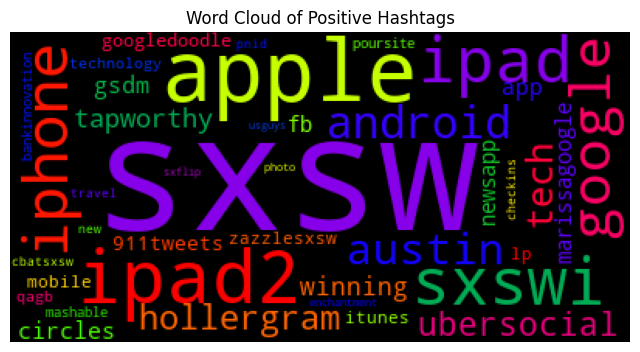

In [31]:
#Positive Sentiment Hashtags Analysis
hashtag_wordcloud_bar(df, 'Positive')

Top Ten Hashtags for Not Positive are: [('sxsw', 5951), ('google', 249), ('apple', 236), ('sxswi', 217), ('iphone', 180), ('ipad', 167), ('ipad2', 164), ('android', 88), ('circles', 80), ('austin', 70), ('tech', 59), ('japan', 51), ('ubersocial', 47), ('gsdm', 47), ('infektd', 46)]


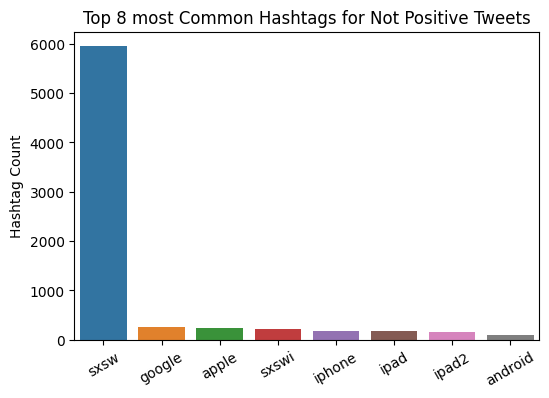

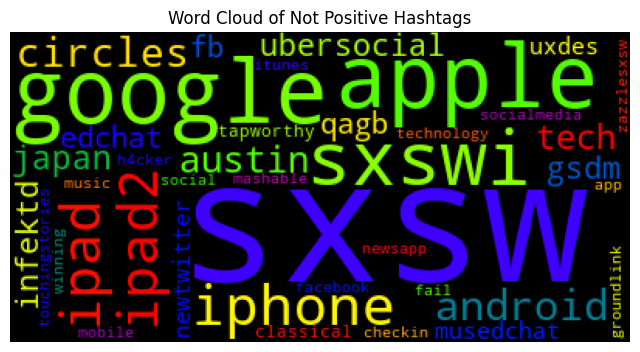

In [32]:
#Not Positive Sentiment Hashtags Analysis

hashtag_wordcloud_bar(df, 'Not Positive')

It seems that the Hashtag rates are very similar across sentiments and upon early inspection it seems unlikely that hashtags will not be a very helpful feature when classifing these tweets by sentiment. It is likely that better results could be gained by adding many of the shared hashtags to the list of stopwords and removing them from the token lists, but instead another route will be taken by looking at the phrases or N-Grams by sentiment. 

## Examing the most common Phrases using Ngrams

Next a bit of the context associated with the tweets will be examined via N-Grams. N-Grams of multple lengths will be examined across sentiment labels to look for differences and similarities. A helper function will be built out to visualize the top N-Grams of a specified N-Gram length in order to simplify this process.

Before this function can be built out a dictionary containing a list of tokens assoicated with each sentiment as well as the overall dataset will be created.


In [33]:
# Creating a list of tweet tokens by Sentiment 

#Listing Sentiment Values
Sentiments = ['Positive', 'Not Positive']

#Creating Empty Lists to extend to 
dfs_list = {}
tokens_list = {}

#Looping through each Sentiment to create a token list exclusive to that sentiment
for sentiment in Sentiments:
    dfs_list['df_{}'.format(sentiment)] = \
        df['Processed_Tweet'].loc[df['Sentiment'] ==  sentiment]
    tokens_list['tokens_{}'.format(sentiment)] = []
    for words in dfs_list['df_{}'.format(sentiment)]:
        tokens_list['tokens_{}'.format(sentiment)].extend(words)
        
#Creating a list that contains all tweet tokens with the entire dataset as well
all_tokens = []
for words in df['Processed_Tweet']:
    all_tokens.extend(words)   
tokens_list['All_Tokens'] = all_tokens

#Displaying Token List Names inside dictionary
tokens_list.keys()

dict_keys(['tokens_Positive', 'tokens_Not Positive', 'All_Tokens'])

In [34]:
#Inspecting number of tokens per sentiment list

print('Number of Positive Tokens:', len(tokens_list['tokens_Positive']))
print('Number of Not Tokens:', len(tokens_list['tokens_Not Positive']))
print('Number of All Tokens:', len(tokens_list['All_Tokens']))

Number of Positive Tokens: 31012
Number of Not Tokens: 59031
Number of All Tokens: 90043


In [35]:
#Creating Frequency Distributions for each token list

all_tokens_count = nltk.FreqDist(tokens_list['All_Tokens'])
pos_tokens_count = nltk.FreqDist(tokens_list['tokens_Positive'])   
not_pos_tokens_count = nltk.FreqDist(tokens_list['tokens_Not Positive'])   


Now that there is a list of tokens as well as frequency distributions of those tokens by sentiment, a helper function will be built out in order to create n-grams of a specified length for each token list and then a visualization of the top n-grams for each sentiment will be created 


In [36]:
def top_ngrams_bars(x, dic_of_token_lists):
    '''
    This Function takes in an designated ngram size number (x) and a dictionary of lists of tokenized words, up to 4 lists. The lists
    The lists of tokens should be strings delimited with commas.
    The function will then create bar charts of the top 8 most common ngrams of the designated ngram size for each list of tokens.
    Each bar chart is titled with the list title 
    '''
    list_names = list(dic_of_token_lists.keys()) #Extracting token list names  
    color_palettes = ['Greens_r', 'Reds_r', 'Blues_r', 'Greys_r'] #Creating list of color palettes 
    
    for list_num in range(len(list_names)):
        ngrams = (pd.Series(nltk.ngrams(dic_of_token_lists[list_names[list_num]], x)).value_counts())[:8] #Taking top 8 most common ngrams of x size
        ngrams_df = pd.DataFrame(ngrams)
        ngrams_df = ngrams_df.reset_index() #Resetting index as it defaults to the ngrams
        ngrams_df = ngrams_df.rename(columns = {'index': 'ngram', 0: 'Count'}) #Renaming df columns for readability 
        
        #Building bar graph of top ngrams
        fig = plt.figure(figsize = (8, 2))
        sns.barplot(data=ngrams_df, x = 'count', y = 'ngram', palette = color_palettes[list_num]).set(title = '{} Top Ngrams'.format(list_names[list_num]))
        plt.xlabel("Number of Occurances")
        plt.ylabel("N-Gram")
        plt.tight_layout()
        
    return plt.show()
       

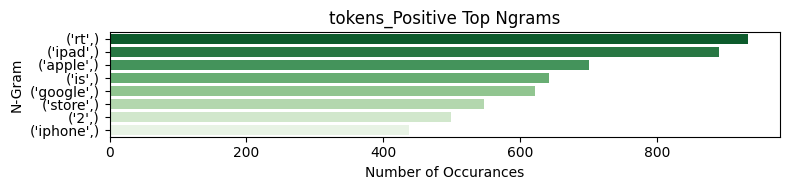

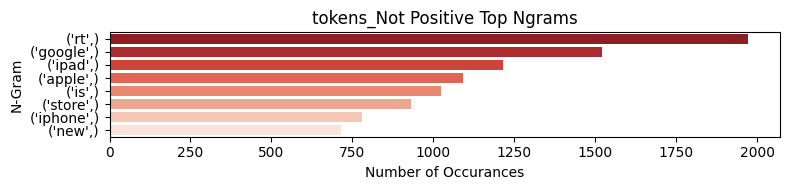

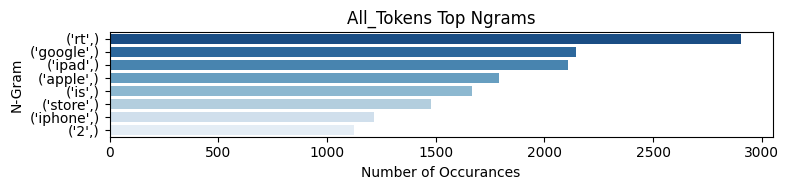

In [37]:
#Top Ngrams of size 1 by sentiment 
top_ngrams_bars(1, tokens_list)

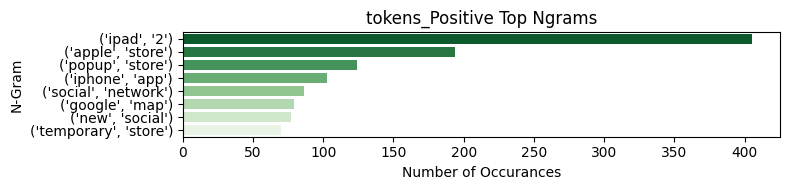

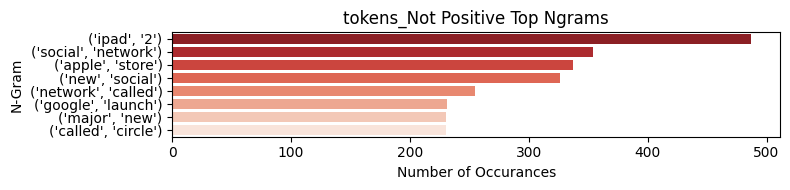

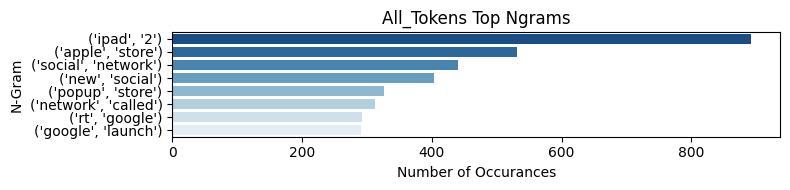

In [38]:
#Top Ngrams of size 2 by sentiment 
top_ngrams_bars(2, tokens_list)

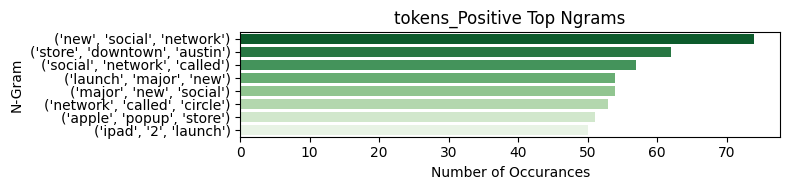

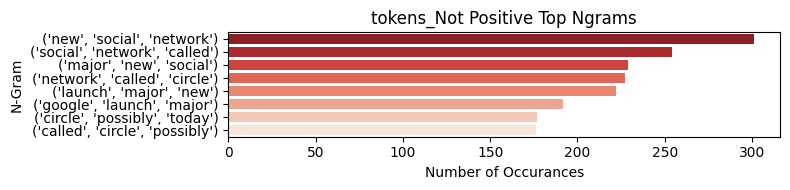

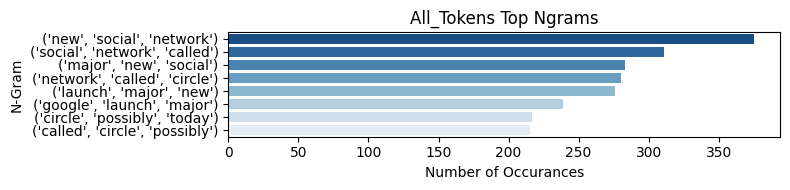

In [39]:
#Top Ngrams of size 3 by sentiment 
top_ngrams_bars(3, tokens_list)

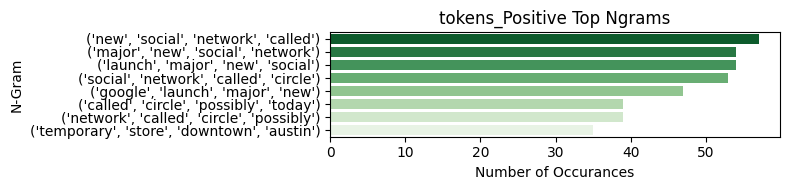

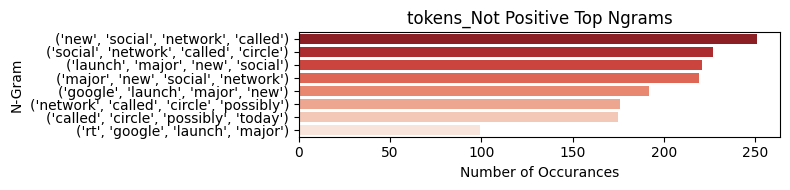

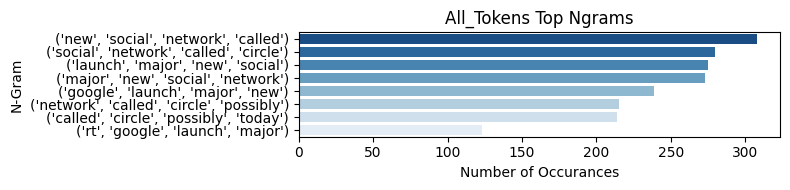

In [40]:
#Top Ngrams of size 4 by sentiment 
top_ngrams_bars(4, tokens_list)

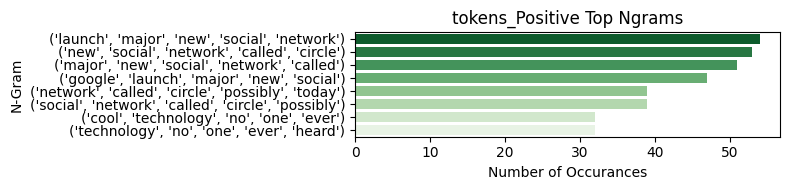

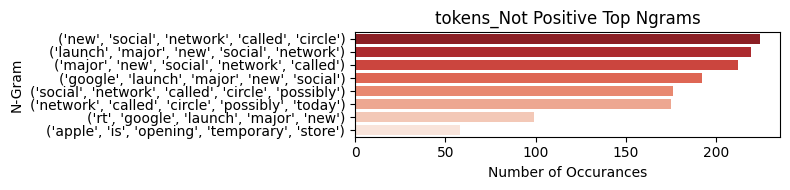

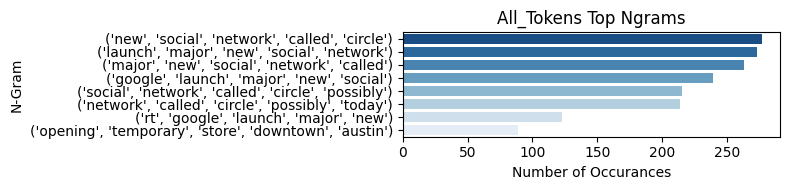

In [41]:
#Top Ngrams of size 5 by sentiment 
top_ngrams_bars(5, tokens_list)

Much like what was seen with the Hashtags, it seems that the n-grams remain very similar across sentiments, even at an n-gram size of 5. This leads me to believe that this will not be the most helpful in categorizing tweet sentiment. Again it is possible that by removing a number of common words the variation among sentiment n-grams may become greater and therefore be of more use, but this feels like sufficient for the current data understanding.

# Modeling 

Through an exploratory data analysis it does not seem that the engineered features will provide much help with our categorical predication model, therefore a Convolutional Natural Language Processing neural network will be built out using the tokenized/lemmanized tweet tokens.

This model will be trained to predict if a tweet has a "Positive" or "Not Positive" sentiment based on the tweet text alone.


## Final Data Prep prior to modeling

Before modeling begins a simplified DataFrame will be built out with only the features that will be relevant to the modeling, from there the tokens will be converted into a list of padded tokenized arrays for input into the model.

In [42]:
#Creating new df with only NLP relevant columns
df_model = df[['Sentiment', 'Processed_Tweet', 'Token Count']]
df_model.head()

,Sentiment,Processed_Tweet,Token Count
0,Not Positive,"[have, 3g, iphone, 3, hr, tweeting, it, wa, de...",13
1,Positive,"[know, awesome, ipadiphone, app, youll, likely...",13
2,Positive,"[can, not, wait, 2, also, should, sale]",7
3,Not Positive,"[hope, year, festival, isnt, crashy, year, iph...",8
4,Positive,"[great, stuff, fri, marissa, mayer, google, ti...",14


In [43]:
#Creating set of all unique words and extracting list length

total_lexicon = set(word for words in df_model['Processed_Tweet'] for word in words)
lexicon_length = len(total_lexicon)
print('Total number of Unique Lemmanized Tokens is',lexicon_length)


Total number of Unique Lemmanized Tokens is 8876


In [44]:
#Using fit_on_texts to index vocabulary based on word frequency

tokenizer = text.Tokenizer(num_words = lexicon_length)
tokenizer.fit_on_texts(list(df_model['Processed_Tweet']))


In order to assure that all tweets are correctly padded to the same length, the longest tweet must be extracted to use as the padding basis.


In [45]:
#Extracting longest token length in lexicon to use as padding basis
df_model['Token Count'].max()


25

In [46]:
#Creating Helper function to 
def df_to_arrays(df):
    '''
    Input a DataFrame with a list of tokenized strings in a "Processed_Tweet" 
    column and a list of padded tokenized arrays is returned.
    
    The "maxlen" parameter should be set equal to the longest tweet in database
    '''
    
    list_tokenized_tweets = tokenizer.texts_to_sequences(df['Processed_Tweet'])
    return sequence.pad_sequences(list_tokenized_tweets, maxlen = 25)


## Train-Test-Validation Splits
Prior to modeling the datase will be split into a training, testing and validation set with a ratio of [8:1:1], this will allow the model to be properly trained and then tested with novel data.

In [152]:


df_model['Sentiment'] = df_model['Sentiment'].map({'Positive': 1, 'Not Positive': 0})

/var/folders/sq/8smv466d46zg1m9_7m_qhdk40000gn/T/ipykernel_34187/2714264394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Sentiment'] = df_model['Sentiment'].map({'Positive': 1, 'Not Positive': 0})


In [153]:
df_model

,Sentiment,Processed_Tweet,Token Count
0,0,"[have, 3g, iphone, 3, hr, tweeting, it, wa, de...",13
1,1,"[know, awesome, ipadiphone, app, youll, likely...",13
2,1,"[can, not, wait, 2, also, should, sale]",7
3,0,"[hope, year, festival, isnt, crashy, year, iph...",8
4,1,"[great, stuff, fri, marissa, mayer, google, ti...",14
...,...,...,...
9088,1,"[ipad, everywhere]",2
9089,0,"[wave, buzz, rt, interrupt, regularly, schedul...",10
9090,0,"[google, zeiger, physician, never, reported, p...",15
9091,0,"[verizon, iphone, customer, complained, time, ...",14


In [209]:
#Defining padded array data and labels
X = df_to_arrays(df_model)
y = df_model['Sentiment']

#Splitting data into training data and remaining data to be split again into test and validation
X_train, X_rem, y_train, y_rem, = train_test_split(X, y, test_size = 0.20, random_state=42)

#Splitting remaining 20% of data evenly between test and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(7131, 25)
(7131,)
(891, 25)
(891,)
(892, 25)
(892,)


(None, None)

In [210]:
#Viewing example of arrays being put into model
print(X_train[0])
y_train

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 280   2  42  98   5  35]


4954    0
2900    0
8102    0
1788    1
973     0
       ..
5846    0
5292    0
5497    1
875     0
7416    1
Name: Sentiment, Length: 7131, dtype: int64

Now we have 3 sets of data in a usable input format, a train, test and validation set splitting the data into a [8:1:1] ratio. The next step will be to setting up the Baseline CNN NLP model.

## Helper Functions for Model Evaluation

Before beginning the modeling stage, a number of helper fuctions will be built out in order to allow for quick and easy model evaluation. These functions will create plots of the training vs validation results in overall loss and accuracy of the models, as well as build out confusion matrices and classifaction reports.

In [232]:
#Function For Model Performance Visualiztion

def final_epoch_stats(results):
    '''
    Input is the results of a CNN model after being fit. Prints out the accuracy and loss statistics for the 
    training and validation sets for the final epoch of the model.
    '''
    history = results.history
    
    #Printing Final Epoch Stats
    print('Final Epoch Stats:')
    print('Training Loss:', history['loss'][-1:])
    print('Training Accuracy:', history['accuracy'][-1:])
    print('------------------------')
    print('Validation Loss:', history['val_loss'][-1:])
    print('Validation Accuracy:', history['val_accuracy'][-1:])

def visualize_model_performance(results):
    '''
    Input is the results after fitting a CNN Sequential model and the output are two graphs, one plots the loss by epoch
    for the training and validation datasets and the second plots a similar graph for accuracy rather than loss.
    '''
    history = results.history
    
    final_epoch_stats(results)
    
    plt.figure(figsize=(10,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Graph of Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Graph of Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()



def make_confusion_and_classification(model, model_name):
    '''
    This function creates a heatmapped confusion matrix as well as a classification report for the model that is input, the
    y_test set is used to compare to the model's X_test predictions to to create the scores. 
    '''
    
    #Show model.evaluate results 
    eval_metrics = model.evaluate(X_train, y_train, verbose=0)
    print('The Accuracy for the training group was', eval_metrics[1]*100)
    print('The Loss for the training group was', eval_metrics[0])
    print('--------------------------------------')
    eval_metrics = model.evaluate(X_test, y_test, verbose=0)
    print('The Accuracy for the test group was', eval_metrics[1]*100)
    print('The Loss for the test group was', eval_metrics[0])
    
    #Make Predictions for model
    preds = model.predict(X_test)
    
    #Create confusion matrix
    conmat = tf.math.confusion_matrix(y_test, preds)
    
    #Create dataframe from confusion matrix
    val = np.mat(conmat)
    #classnames = list(set(y_train))
    df_cm = pd.DataFrame(val)
    
    #generate heatmap confusion matrix
    plt.figure()
    heatmap = sns.heatmap(df_cm, annot=True, cmap='Reds',fmt='g')
    heatmap.yaxis.set_ticklabels(['Not Positive', 'Positive'], rotation=0)
    heatmap.xaxis.set_ticklabels(['Not Positive', 'Positive'], rotation=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(model_name)
    plt.show()
    
    #generate classification report
    print(classification_report(y_test, np.argmax(preds, axis=1)))

## Baseline Model

Modeling will start off with a fairly basic CNN sequential model that contains 3 dense layers and will be compiled for accuracy and categorical crossentropy as the loss metric via the "adam' optimizer. From there the model will be iterated on to improve the overall classification results.

In [187]:
baseline_model = Sequential()

baseline_model.add(layers.Dense(128, activation='relu', input_shape=(25,)))
baseline_model.add(layers.Dense(64, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

baseline_model.compile(optimizer='adam',metrics=['accuracy'], loss='binary_crossentropy')
baseline_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 128)               3328      
                                                                 
 dense_99 (Dense)            (None, 64)                8256      
                                                                 
 dense_100 (Dense)           (None, 1)                 65        
                                                                 
Total params: 11649 (45.50 KB)
Trainable params: 11649 (45.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [229]:
baseline_results = baseline_model.fit(X_train, y_train, epochs=100, batch_size=50,
                                  validation_data=(X_val, y_val), verbose = 1)

Epoch 1/100
143/143 [==============================] - 0s 672us/step - loss: 0.3337 - accuracy: 0.8445 - val_loss: 2.2916 - val_accuracy: 0.6072
Epoch 2/100
143/143 [==============================] - 0s 598us/step - loss: 0.3462 - accuracy: 0.8363 - val_loss: 2.1526 - val_accuracy: 0.6274
Epoch 3/100
143/143 [==============================] - 0s 575us/step - loss: 0.3324 - accuracy: 0.8410 - val_loss: 2.3793 - val_accuracy: 0.6296
Epoch 4/100
143/143 [==============================] - 0s 569us/step - loss: 0.3629 - accuracy: 0.8309 - val_loss: 2.2069 - val_accuracy: 0.6083
Epoch 5/100
143/143 [==============================] - 0s 572us/step - loss: 0.3762 - accuracy: 0.8246 - val_loss: 1.8745 - val_accuracy: 0.6207
Epoch 6/100
143/143 [==============================] - 0s 576us/step - loss: 0.3554 - accuracy: 0.8323 - val_loss: 2.0254 - val_accuracy: 0.6184
Epoch 7/100
143/143 [==============================] - 0s 569us/step - loss: 0.3370 - accuracy: 0.8410 - val_loss: 2.0505 - val_ac

143/143 [==============================] - 0s 556us/step - loss: 0.2939 - accuracy: 0.8607 - val_loss: 2.7017 - val_accuracy: 0.6397
Epoch 58/100
143/143 [==============================] - 0s 551us/step - loss: 0.2955 - accuracy: 0.8586 - val_loss: 2.6496 - val_accuracy: 0.6510
Epoch 59/100
143/143 [==============================] - 0s 555us/step - loss: 0.3112 - accuracy: 0.8535 - val_loss: 2.4426 - val_accuracy: 0.6375
Epoch 60/100
143/143 [==============================] - 0s 545us/step - loss: 0.3012 - accuracy: 0.8557 - val_loss: 2.7062 - val_accuracy: 0.6263
Epoch 61/100
143/143 [==============================] - 0s 558us/step - loss: 0.3623 - accuracy: 0.8368 - val_loss: 2.3811 - val_accuracy: 0.6521
Epoch 62/100
143/143 [==============================] - 0s 547us/step - loss: 0.3903 - accuracy: 0.8316 - val_loss: 2.4085 - val_accuracy: 0.6218
Epoch 63/100
143/143 [==============================] - 0s 552us/step - loss: 0.4069 - accuracy: 0.8226 - val_loss: 2.3505 - val_accuracy

In [245]:
y_train.value_counts()

Sentiment
0    4750
1    2381
Name: count, dtype: int64

The Accuracy for the training group was 86.62179112434387
The Loss for the training group was 0.28639736771583557
--------------------------------------
The Accuracy for the test group was 62.33183741569519
The Loss for the test group was 3.242032527923584
28/28 [==============================] - 0s 276us/step


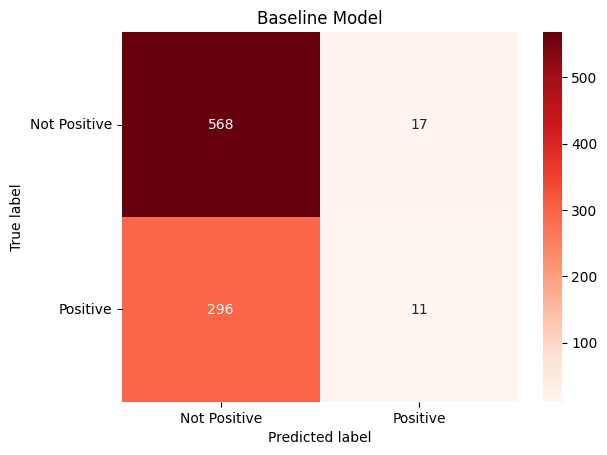

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       585
           1       0.00      0.00      0.00       307

    accuracy                           0.66       892
   macro avg       0.33      0.50      0.40       892
weighted avg       0.43      0.66      0.52       892

Final Epoch Stats:
Training Loss: [0.312330037355423]
Training Accuracy: [0.8569625616073608]
------------------------
Validation Loss: [2.740950107574463]
Validation Accuracy: [0.6531986594200134]


/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

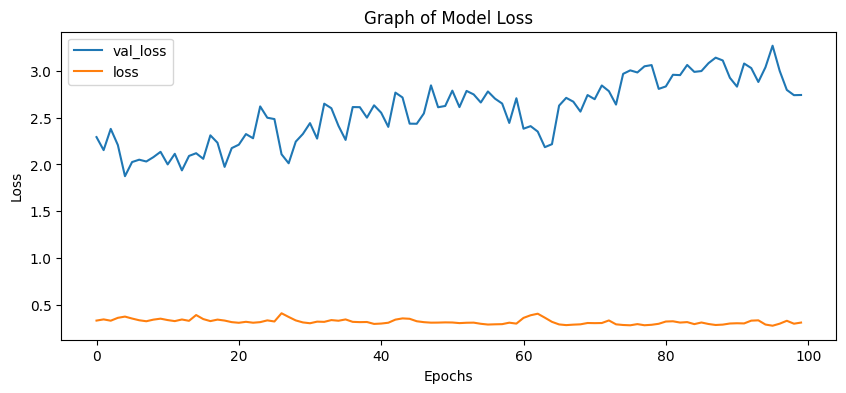

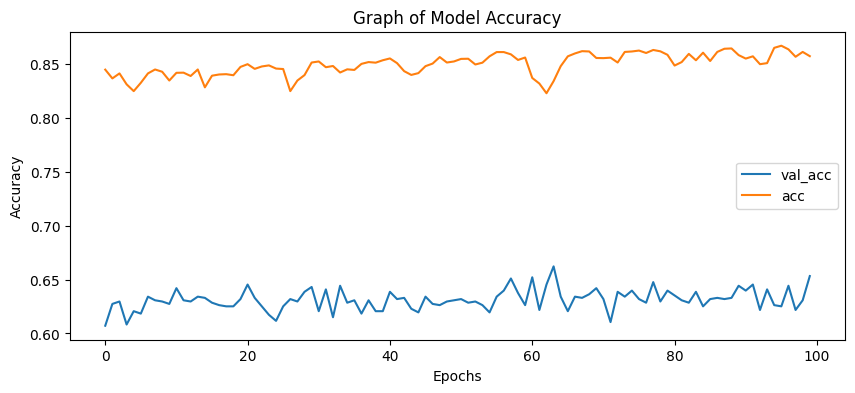

In [233]:
make_confusion_and_classification(baseline_model, 'Baseline Model')
visualize_model_performance(baseline_results)


## Baseline Model Analysis

As can be seen by the above charts, the baseline model did alright with accuracy generally increases and loss decreases in both the training and validation set as epochs proceed. This model is currently quite overfit with the training data being signicantly more accurately labeled (\~72%) than the validation data (~64%) after training the modeling. 

In the next iteration of the model, a dropout layer will be added after the first dense layer at a rate of 0.2 to help mend the over fitting issue.

An Early stop based on the validation set's accuracy will also be added to assure efficient use of resources.

## Model 2
 
As mentioned above the first iteration on the baseline model will contain a dropout layer in the hope that it helps with the model's overfitting issue. An early stop will also be added.

In [53]:
#Introducing Early stop based on val_accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#declare checkpoint variable and early stopping to get best model
early_stop = [EarlyStopping(monitor = 'val_accuracy', patience = 15),
              ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

In [234]:
model2 = Sequential()

model2.add(layers.Dense(128, activation='relu', input_shape=(25,)))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 128)               3328      
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_129 (Dense)           (None, 64)                8256      
                                                                 
 dense_130 (Dense)           (None, 1)                 65        
                                                                 
Total params: 11649 (45.50 KB)
Trainable params: 11649 (45.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [235]:
model2_results = model2.fit(X_train, y_train, epochs=100, batch_size=20,
                    validation_data=(X_val, y_val), verbose = 1,
                   callbacks=early_stop)

Epoch 1/100
357/357 [==============================] - 0s 632us/step - loss: 45.2924 - accuracy: 0.5552 - val_loss: 20.6504 - val_accuracy: 0.5129
Epoch 2/100
357/357 [==============================] - 0s 517us/step - loss: 18.9841 - accuracy: 0.5644 - val_loss: 10.7581 - val_accuracy: 0.6184
Epoch 3/100
357/357 [==============================] - 0s 513us/step - loss: 11.2471 - accuracy: 0.5681 - val_loss: 7.2420 - val_accuracy: 0.5578
Epoch 4/100
357/357 [==============================] - 0s 507us/step - loss: 6.5387 - accuracy: 0.5785 - val_loss: 3.8941 - val_accuracy: 0.5724
Epoch 5/100
357/357 [==============================] - 0s 523us/step - loss: 4.6830 - accuracy: 0.5764 - val_loss: 2.4088 - val_accuracy: 0.6240
Epoch 6/100
357/357 [==============================] - 0s 513us/step - loss: 2.9556 - accuracy: 0.5838 - val_loss: 1.6941 - val_accuracy: 0.6195
Epoch 7/100
357/357 [==============================] - 0s 522us/step - loss: 2.1585 - accuracy: 0.5873 - val_loss: 1.3118 - v

The Accuracy for the training group was 66.72276258468628
The Loss for the training group was 0.6469637155532837
--------------------------------------
The Accuracy for the test group was 65.58296084403992
The Loss for the test group was 0.6656011939048767
28/28 [==============================] - 0s 328us/step


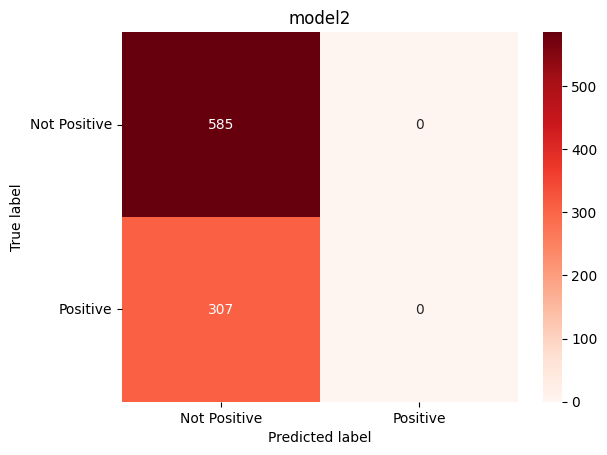

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       585
           1       0.00      0.00      0.00       307

    accuracy                           0.66       892
   macro avg       0.33      0.50      0.40       892
weighted avg       0.43      0.66      0.52       892

Final Epoch Stats:
Training Loss: [0.6547573804855347]
Training Accuracy: [0.6582527160644531]
------------------------
Validation Loss: [0.651455283164978]
Validation Accuracy: [0.6823793649673462]


/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

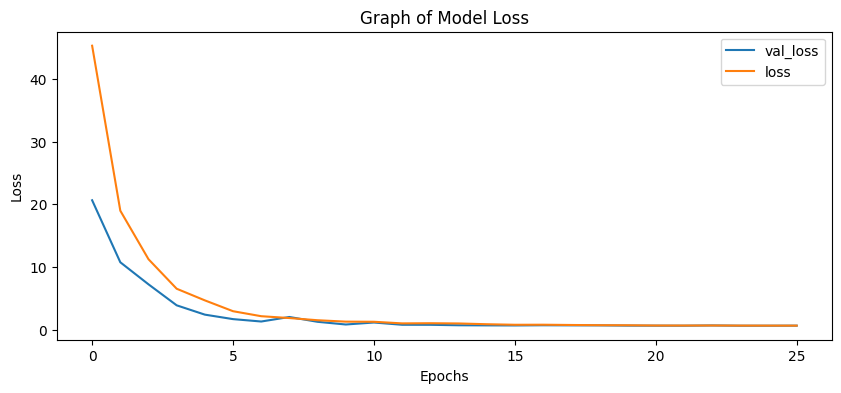

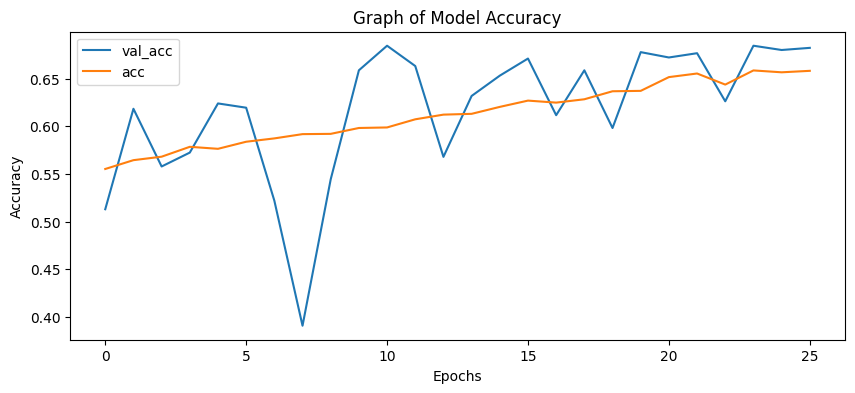

In [237]:
make_confusion_and_classification(model2, 'model2')
visualize_model_performance(model2_results)

### Second Model Analysis 

This second version of the model with the dropout layer inplace is already significantly less overfit than the baseline model with the training and validation metrics being much more similar. The final epoch had training and validation accuracies of 66% and 65% respectively, as well as both of the loss metrics being about 0.64. 

The accuracy on the training model has dipped about 6% but the validation set raised about a percent which is a step in the right direction.

An Additonal Dense layer will be added in hopes of improving the model further.

## Model 3 - L2 Regularization


In [223]:
model3 = Sequential()

model3.add(layers.Dense(128, activation='relu', input_shape=(25,), kernel_regularizer=regularizers.l2(0.02)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(1, activation='softmax'))


optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)

model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

model3_results = model3.fit(X_train, y_train, epochs=100, batch_size=20,
                    validation_data=(X_val, y_val), verbose = 1,
                   callbacks=early_stop)


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 128)               3328      
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_119 (Dense)           (None, 64)                8256      
                                                                 
 dense_120 (Dense)           (None, 16)                1040      
                                                                 
 dense_121 (Dense)           (None, 1)                 17        
                                                                 
Total params: 12641 (49.38 KB)
Trainable params: 12641 (49.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
 97/3

/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


357/357 [==============================] - 0s 692us/step - loss: 16.8109 - accuracy: 0.3339 - val_loss: 57.1191 - val_accuracy: 0.3165
Epoch 2/100
357/357 [==============================] - 0s 528us/step - loss: 153.0772 - accuracy: 0.3339 - val_loss: 275.8912 - val_accuracy: 0.3165
Epoch 3/100
357/357 [==============================] - 0s 517us/step - loss: 444.9825 - accuracy: 0.3339 - val_loss: 635.9215 - val_accuracy: 0.3165
Epoch 4/100
357/357 [==============================] - 0s 535us/step - loss: 864.6500 - accuracy: 0.3339 - val_loss: 1112.3217 - val_accuracy: 0.3165
Epoch 5/100
357/357 [==============================] - 0s 590us/step - loss: 1394.1611 - accuracy: 0.3339 - val_loss: 1689.6272 - val_accuracy: 0.3165
Epoch 6/100
357/357 [==============================] - 0s 539us/step - loss: 2011.6522 - accuracy: 0.3339 - val_loss: 2356.8816 - val_accuracy: 0.3165
Epoch 7/100
357/357 [==============================] - 0s 554us/step - loss: 2720.2827 - accuracy: 0.3339 - val_los

The Accuracy for the training group was 33.38942527770996
The Loss for the training group was 12405.7734375
--------------------------------------
The Accuracy for the test group was 34.41703915596008
The Loss for the test group was 12405.7978515625
28/28 [==============================] - 0s 333us/step


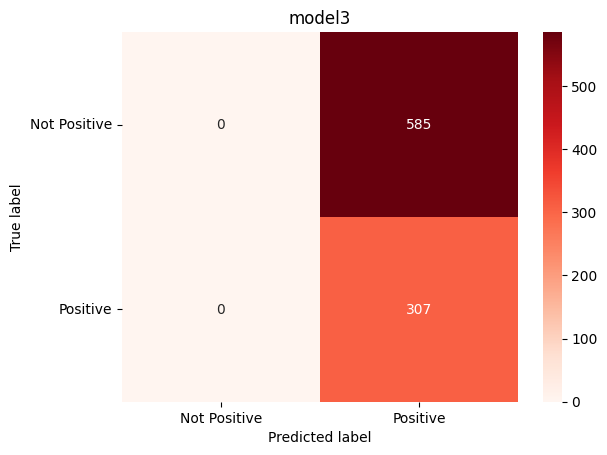

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       585
           1       0.00      0.00      0.00       307

    accuracy                           0.66       892
   macro avg       0.33      0.50      0.40       892
weighted avg       0.43      0.66      0.52       892

Final Epoch Stats:
Training Loss: [11765.623046875]
Training Accuracy: [0.3338942527770996]
------------------------
Validation Loss: [12405.798828125]
Validation Accuracy: [0.3164983093738556]


/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

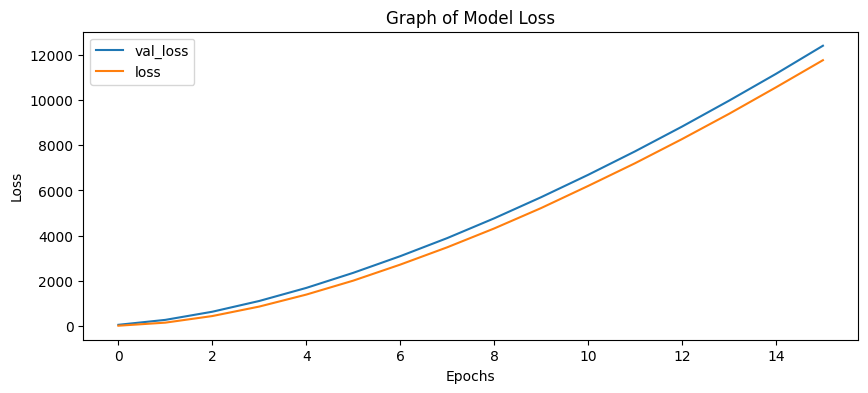

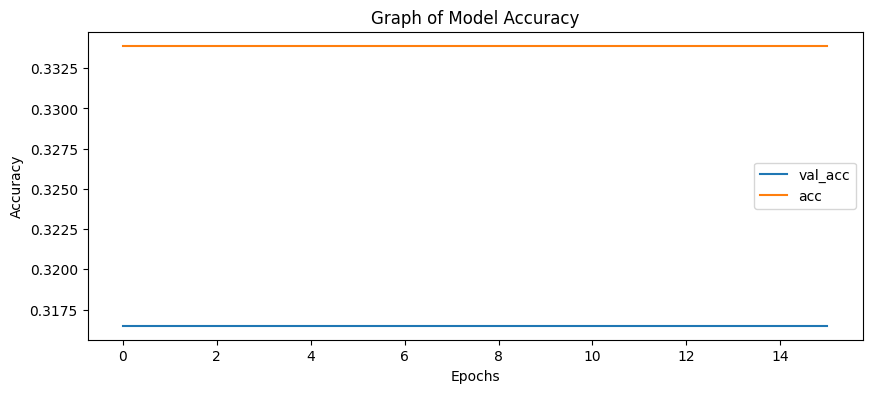

In [236]:
make_confusion_and_classification(model3, 'model3')
visualize_model_performance(model3_results)

## Model 3 Analysis

The third iteration of this model with the addition of l2 regularization in the first two dense nodes did not improve the accuracy of the model and increased the loss metric, an overall worse model.

A fourth model will be trained using L1 regularization rather than L2 to see if there is any noticable improvement.

## Model 4 - L1 Regularization

In [82]:
model4 = Sequential()

model4.add(layers.Dense(128, activation='relu', input_shape=(25,), kernel_regularizer=regularizers.l1(0.01)))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model4.add(layers.Dense(16, activation='relu'))
model4.add(layers.Dense(2, activation='softmax'))


optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)

model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

model4_results = model4.fit(X_train, y_train, epochs=100, batch_size=20,
                    validation_data=(X_val, y_val), verbose = 1,
                   callbacks=early_stop)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 128)               3328      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dense_45 (Dense)            (None, 16)                1040      
                                                                 
 dense_46 (Dense)            (None, 2)                 34        
                                                                 
Total params: 12658 (49.45 KB)
Trainable params: 12658 (49.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
357/3

The Accuracy for the test group was 68.83407831192017
The Loss for the test group was 1.5792429447174072
28/28 [==============================] - 0s 339us/step


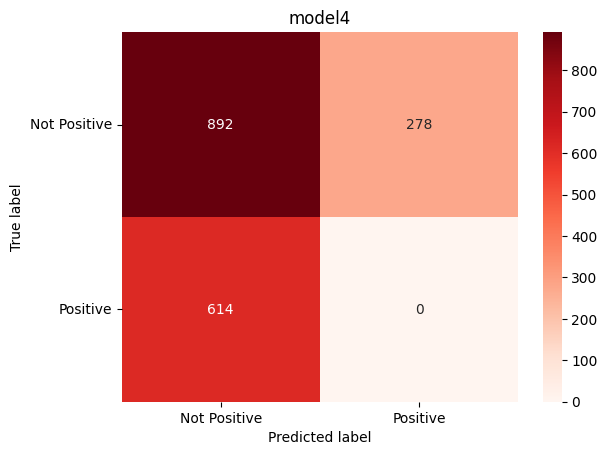

              precision    recall  f1-score   support

           0       0.69      1.00      0.82       614
           1       0.00      0.00      0.00       278

    accuracy                           0.69       892
   macro avg       0.34      0.50      0.41       892
weighted avg       0.47      0.69      0.56       892

Final Epoch Stats:
Training Loss: [1.8591715097427368]
Training Accuracy: [0.6659654974937439]
------------------------
Validation Loss: [1.6057734489440918]
Validation Accuracy: [0.650954008102417]


/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

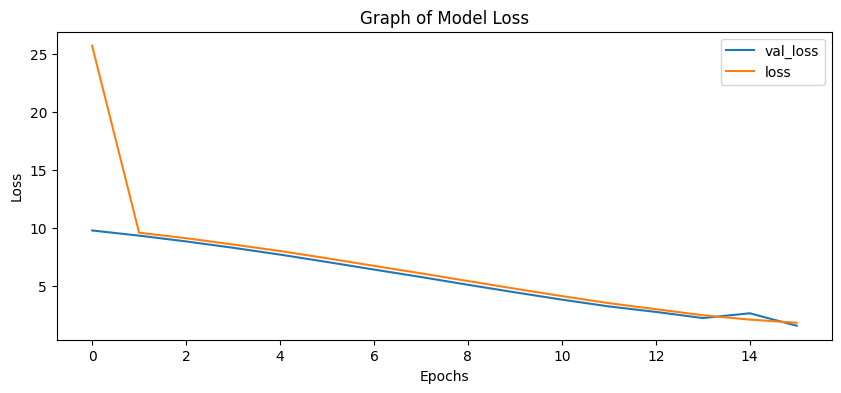

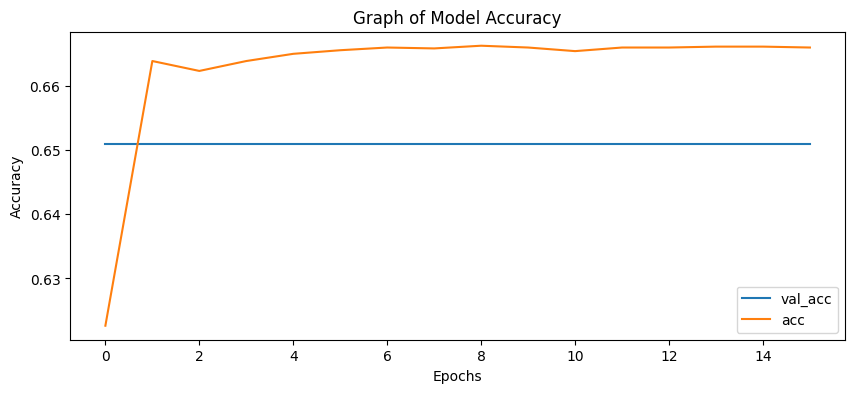

In [126]:
make_confusion_and_classification(model4, 'model4')
visualize_model_performance(model4_results)

## Model 4 Analysis

The fourth iteration of this model which utalized L1 regularization in the first two dense nodes did not improve the accuracy of the model and increased the loss metric significantly when compared to the last two iterations of this model, leaving the model2 as our current best iteration.

A fifth model will be trained using a different thought process, this will be referred to as model_b moving forward.


## Model B - Embedding, LSTM and GlobalMaxPool1D

Model B makes use of Embedding, LSTM and the globalmaxpool1d nodes as well as an additional dense layer set to 16. This was created in an attempt to try a slightly different modeling approach.

In [86]:
model_b = Sequential()

model_b.add(Embedding(input_dim = lexicon_length, output_dim = 128, input_length = 25))
model_b.add(LSTM(128, return_sequences = True))
model_b.add(GlobalMaxPool1D())
model_b.add(Dense(64, activation='relu'))
model_b.add(Dense(16, activation='relu'))
model_b.add(Dense(2, activation='softmax'))


opt = keras.optimizers.legacy.Adam(learning_rate=0.0012)
model_b.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_b.summary()

model_b_results = model_b.fit(X_train, y_train, epochs=100, batch_size=20,
                    validation_data=(X_val, y_val), verbose = 1,
                   callbacks=early_stop)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 128)           1136128   
                                                                 
 lstm_5 (LSTM)               (None, 25, 128)           131584    
                                                                 
 global_max_pooling1d_5 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_47 (Dense)            (None, 64)                8256      
                                                                 
 dense_48 (Dense)            (None, 16)                1040      
                                                                 
 dense_49 (Dense)            (None, 2)                 34        
                                                     

The Accuracy for the test group was 73.87892603874207
The Loss for the test group was 1.9364830255508423
28/28 [==============================] - 0s 4ms/step


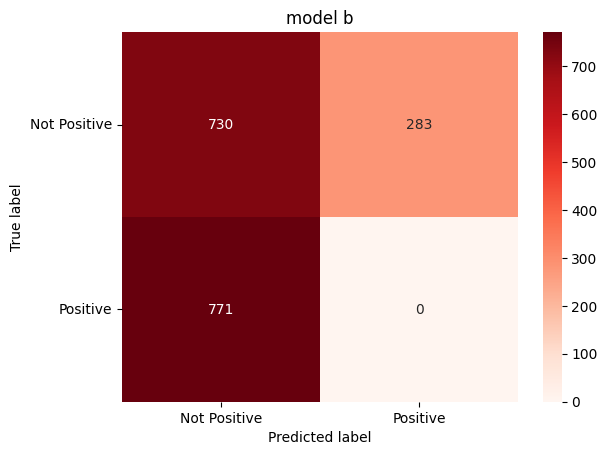

              precision    recall  f1-score   support

           0       0.80      0.84      0.81       614
           1       0.59      0.53      0.56       278

    accuracy                           0.74       892
   macro avg       0.69      0.68      0.69       892
weighted avg       0.73      0.74      0.73       892

Final Epoch Stats:
Training Loss: [0.06221907585859299]
Training Accuracy: [0.9706913232803345]
------------------------
Validation Loss: [1.8856091499328613]
Validation Accuracy: [0.7182940244674683]


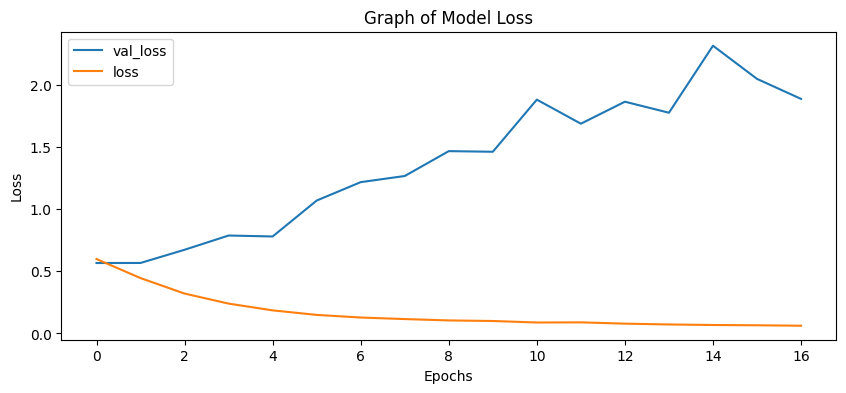

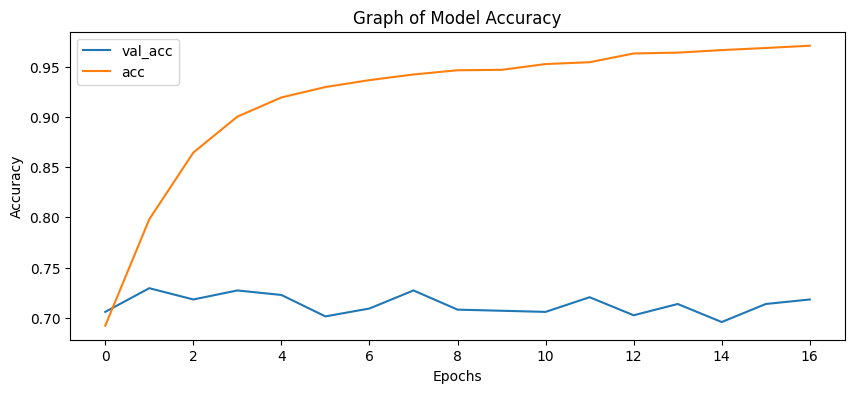

In [127]:
make_confusion_and_classification(model_b, 'model b')
visualize_model_performance(model_b_results)

## Model B Analysis

Model B is fairly overfit so like before, a dropout layer will be added in an attempt to mend this overfitting.


## Model B2 - Adding a Dropout layer

In [90]:
model_b2 = Sequential()

model_b2.add(Embedding(input_dim = lexicon_length, output_dim = 128, input_length = 25))
model_b2.add(LSTM(128, return_sequences = True))
model_b2.add(GlobalMaxPool1D())
model_b2.add(Dense(64, activation='relu'))
model_b2.add(Dropout(0.3))
model_b2.add(Dense(16, activation='relu'))
model_b2.add(Dense(2, activation='softmax'))


opt = keras.optimizers.legacy.Adam(learning_rate=0.0012)
model_b2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_b2.summary()

model_b2_results = model_b2.fit(X_train, y_train, epochs=100, batch_size=20,
                    validation_data=(X_val, y_val), verbose = 1,
                   callbacks=early_stop)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 128)           1136128   
                                                                 
 lstm_7 (LSTM)               (None, 25, 128)           131584    
                                                                 
 global_max_pooling1d_7 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 16)                1040      
                                                     

The Accuracy for the test group was 70.29147744178772
The Loss for the test group was 2.469926118850708
28/28 [==============================] - 0s 4ms/step


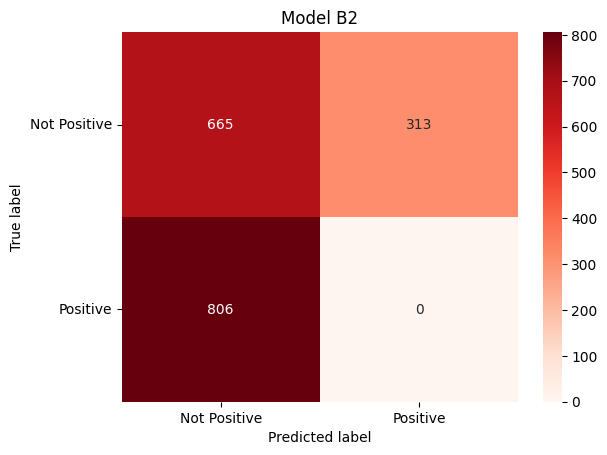

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       614
           1       0.52      0.58      0.55       278

    accuracy                           0.70       892
   macro avg       0.66      0.67      0.66       892
weighted avg       0.71      0.70      0.71       892

Final Epoch Stats:
Training Loss: [0.06908756494522095]
Training Accuracy: [0.9692890048027039]
------------------------
Validation Loss: [2.4514269828796387]
Validation Accuracy: [0.7048260569572449]


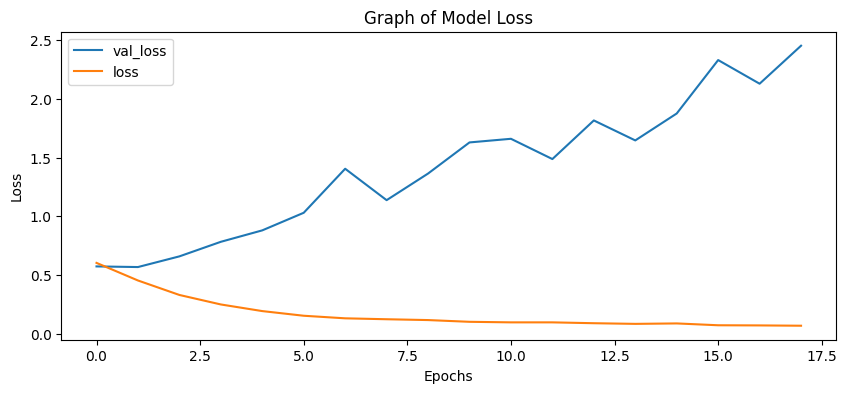

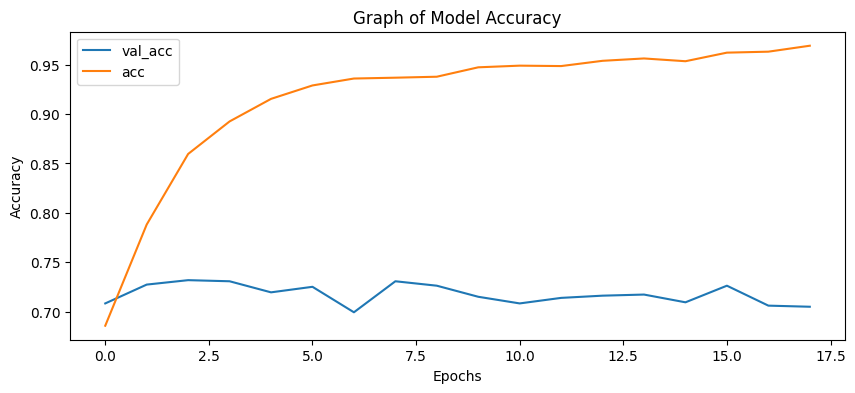

In [128]:
make_confusion_and_classification(model_b2, 'Model B2')
visualize_model_performance(model_b2_results)

## Model B2 Analysis

This model is still fairly overfit with a training accuracy approaching 97% and a validation accuracy closer to 70%. The loss metric alos increases for the validation group as epochs persist. 

Due to our classifications being unbalanced in the data set, the weight of each class will be determined and then applied to the best iterations of both of the current models.

## Calculating and adding a class weights metric

### Determining Class weights

In [130]:
#Calculation Class weights 

#Total number of samples
n_samples = len(df_model)
#Total number of classification labels
n_classes = 2
#Calculating total number of positve and not positive samlpes
n_sample_pos = len(df_model[df_model['Sentiment'] == 'Positive'])
n_sample_not_pos = len(df_model[df_model['Sentiment'] == 'Not Positive'])

#Dividing to find weights for each class
class_weight_pos = n_samples / (n_classes * n_sample_pos)
class_weight_not_pos = n_samples / (n_classes * n_sample_not_pos)

class_weights = {1: class_weight_not_pos,
                0: class_weight_pos}

class_weights

{1: 0.7498317631224765, 0: 1.5006734006734006}

## Model 2_2 - Adding Class weights

In [227]:
model2_2 = Sequential()

model2_2.add(layers.Dense(128, activation='relu', input_shape=(25,)))
model2_2.add(layers.Dropout(0.2))
model2_2.add(layers.Dense(64, activation='relu'))
model2_2.add(layers.Dense(1, activation='softmax'))

model2_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2_2.summary()

model2_2_results = model2_2.fit(X_train, y_train, epochs=100, batch_size=20,
                    validation_data=(X_val, y_val), verbose = 1,
                   callbacks=early_stop, class_weight=class_weights)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 128)               3328      
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_126 (Dense)           (None, 64)                8256      
                                                                 
 dense_127 (Dense)           (None, 1)                 65        
                                                                 
Total params: 11649 (45.50 KB)
Trainable params: 11649 (45.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
 99/357 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3424 

/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


357/357 [==============================] - 0s 672us/step - loss: 0.0000e+00 - accuracy: 0.3339 - val_loss: 0.0000e+00 - val_accuracy: 0.3165
Epoch 2/100
357/357 [==============================] - 0s 526us/step - loss: 0.0000e+00 - accuracy: 0.3339 - val_loss: 0.0000e+00 - val_accuracy: 0.3165
Epoch 3/100
357/357 [==============================] - 0s 516us/step - loss: 0.0000e+00 - accuracy: 0.3339 - val_loss: 0.0000e+00 - val_accuracy: 0.3165
Epoch 4/100
357/357 [==============================] - 0s 517us/step - loss: 0.0000e+00 - accuracy: 0.3339 - val_loss: 0.0000e+00 - val_accuracy: 0.3165
Epoch 5/100
357/357 [==============================] - 0s 528us/step - loss: 0.0000e+00 - accuracy: 0.3339 - val_loss: 0.0000e+00 - val_accuracy: 0.3165
Epoch 6/100
357/357 [==============================] - 0s 519us/step - loss: 0.0000e+00 - accuracy: 0.3339 - val_loss: 0.0000e+00 - val_accuracy: 0.3165
Epoch 7/100
357/357 [==============================] - 0s 507us/step - loss: 0.0000e+00 - accu

The Accuracy for the test group was 34.41703915596008
The Loss for the test group was 0.0
28/28 [==============================] - 0s 347us/step


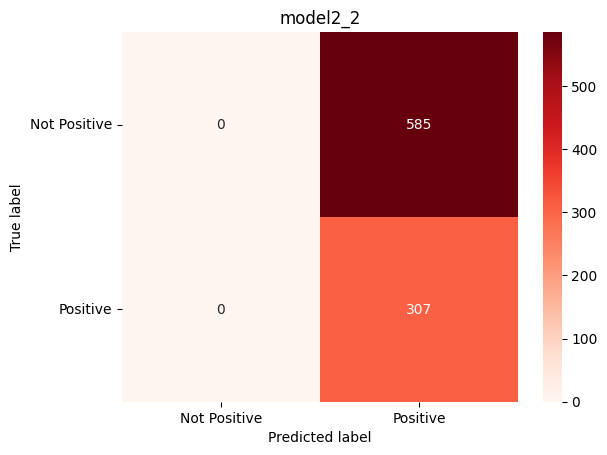

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       585
           1       0.00      0.00      0.00       307

    accuracy                           0.66       892
   macro avg       0.33      0.50      0.40       892
weighted avg       0.43      0.66      0.52       892

Final Epoch Stats:
Training Loss: [0.0]
Training Accuracy: [0.3338942527770996]
------------------------
Validation Loss: [0.0]
Validation Accuracy: [0.3164983093738556]


/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

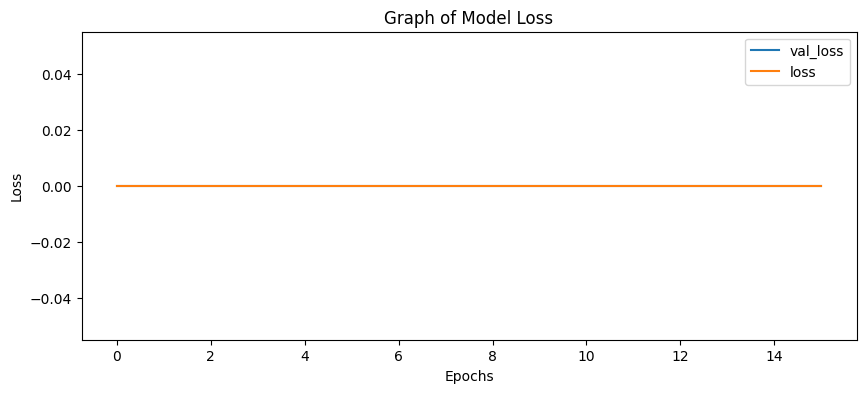

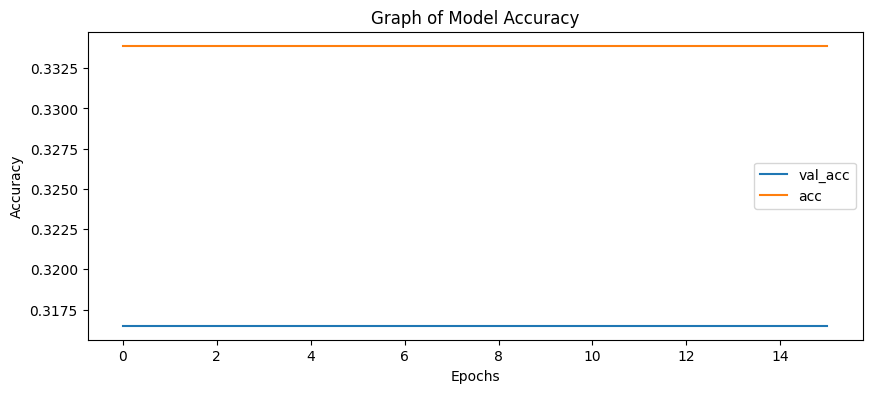

In [228]:
make_confusion_and_classification(model2_2, 'model2_2')
visualize_model_performance(model2_2_results)

## Model 2_2 Analysis

The Accuracy of this model was all over the place in terms of accuracy as epochs persisted, overall the validation of both the training group and validation group were lower than that of other models, currently model2 is the best performing model.

## Model B2_2 - Adding Class weights

In [102]:
model_b2_2 = Sequential()

model_b2_2.add(Embedding(input_dim = lexicon_length, output_dim = 128, input_length = 25))
model_b2_2.add(LSTM(128, return_sequences = True))
model_b2_2.add(GlobalMaxPool1D())
model_b2_2.add(Dense(64, activation='relu'))
model_b2_2.add(Dropout(0.2))
model_b2_2.add(Dense(16, activation='relu'))
model_b2_2.add(Dense(2, activation='softmax'))


opt = keras.optimizers.legacy.Adam(learning_rate=0.0012)
model_b2_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_b2_2.summary()

model_b2_2_results = model_b2_2.fit(X_train, y_train, epochs=100, batch_size=20,
                    validation_data=(X_val, y_val), verbose = 1,
                   callbacks=early_stop, class_weight=class_weights)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 25, 128)           1136128   
                                                                 
 lstm_11 (LSTM)              (None, 25, 128)           131584    
                                                                 
 global_max_pooling1d_11 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_69 (Dense)            (None, 16)                1040      
                                                     

The Accuracy for the test group was 72.08520174026489
The Loss for the test group was 1.8912354707717896
28/28 [==============================] - 0s 4ms/step


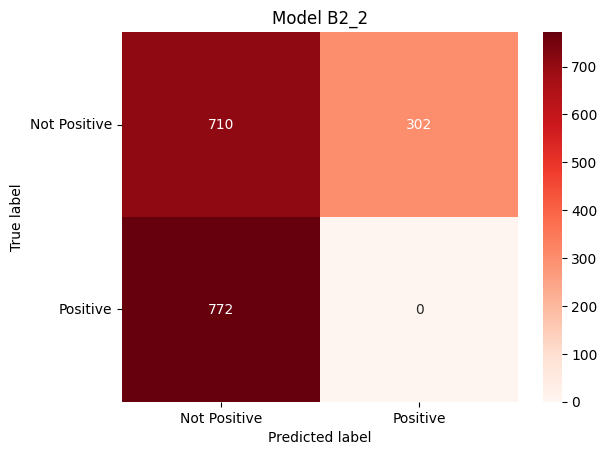

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       614
           1       0.54      0.69      0.61       278

    accuracy                           0.72       892
   macro avg       0.69      0.71      0.70       892
weighted avg       0.75      0.72      0.73       892

Final Epoch Stats:
Training Loss: [0.07555769383907318]
Training Accuracy: [0.9608750343322754]
------------------------
Validation Loss: [2.1505775451660156]
Validation Accuracy: [0.6756453514099121]


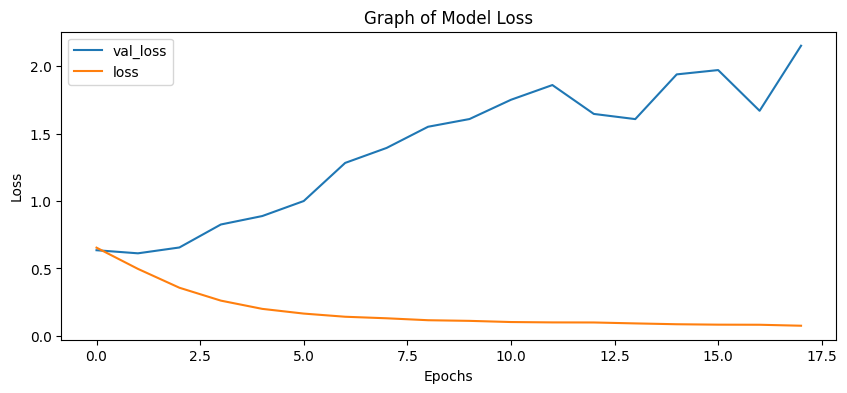

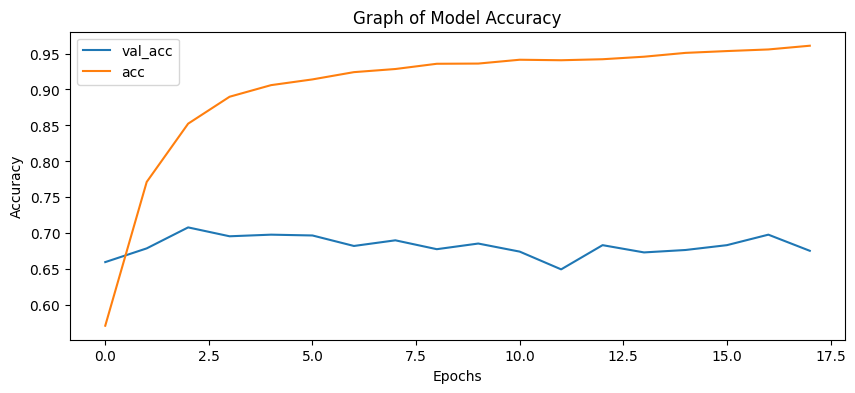

In [133]:
make_confusion_and_classification(model_b2_2, 'Model B2_2')
visualize_model_performance(model_b2_2_results)

## Model B2_2 Analyisis

This Model is still quite overfit, leaving the best model to be Model2, going forward this model will be used as the final model of this project. 

A deeper analysis of this model followed by some practical recommendations for the shareholders will commence below.

# Final Model Analysis 

At this point multiple iterations of two different model schemes have been built out and iterated on, from here the best performing model will be chosen and then mined for its uses in fulfilling the purposes of this project

# Conclusion

# Attempting a Gridsearch



In [67]:
def getModel():
    model_func = Sequential()
    model_func.add(Embedding(input_dim = lexicon_length, output_dim = 128, input_length = 25))
    model_func.add(LSTM(128, return_sequences = True))
    model_func.add(GlobalMaxPool1D())
    model_func.add(Dense(64, activation='relu'))
    model_func.add(Dense(16, activation='relu'))
    model_func.add(Dense(2, activation='softmax'))

    #opt = keras.optimizers.legacy.Adam()
    model_func.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_func

Kmodel = KerasClassifier(model=getModel, verbose=1)

from sklearn.model_selection import GridSearchCV

param_grid =dict(epochs =[1, 2])
            #'batch_size': [20 ,40]}
            #'optimizer__learn_rate' : [0.001, 0.01, 0.1],
            #'optimizer__momentum' : [ 0.2, 0.4]}

grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, n_jobs=-1, cv=3, scoring="accuracy",error_score="raise")



In [68]:
grid_results = grid.fit(X_train, y_train, validation_data=(X_val, y_val), verbose = 1,
                   class_weight=class_weights)



Epoch 1/2
Epoch 1/2
Epoch 1/2
149/149 [==============================] - 11s 64ms/step - loss: 0.6826 - accuracy: 0.5726 - val_loss: 0.6508 - val_accuracy: 0.6554
Epoch 2/2


AttributeError: 'str' object has no attribute '__name__'

In [ ]:
best_params=grid_results.best_params_
accuracy=grid_results.best_score_

In [ ]:
def model_maker():
    model = Sequential()
    model.add(Dense(24, input_shape=(25,), activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

batch_size = [1]
epochs = [1]
param_grid = dict(batch_size=batch_size, epochs=epochs)

model = KerasClassifier(model=model_maker, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, error_score='raise')
g_results = grid.fit(X_train, y_train ,validation_data=(X_val, y_val), verbose = 1 )

